# **User Story 1: Improve the robustness of anamoly detection using ensemble techniques**

### **Task 1: Select relevant features or create new ones to improve the performance of the Isolation Forest model, ensuring that the features used are informative for detecting anomalies.**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder



In [17]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx', sheet_name='export-token-0x85f17cf997934a59')

# Feature Engineering (as per your notebook)
data['Hour'] = pd.to_datetime(data['UnixTimestamp'], unit='s').dt.hour
data['Log_Quantity'] = np.log1p(data['Quantity'])
data['From_Transaction_Count'] = data['From'].map(data['From'].value_counts())
data['To_Transaction_Count'] = data['To'].map(data['To'].value_counts())
data['Time_Interval'] = data['UnixTimestamp'].diff().fillna(0)

# Create a directed graph from the transaction data
G = nx.DiGraph()

# Add edges to the graph with weights as Quantity
edges = data[['From', 'To', 'Quantity']].values
G.add_weighted_edges_from(edges)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

# Add these features to the original dataset
data['Degree Centrality'] = data['From'].map(degree_centrality)
data['Betweenness Centrality'] = data['From'].map(betweenness_centrality)
data['Closeness Centrality'] = data['From'].map(closeness_centrality)

# 1. Interaction term
data['Log_Quantity_Time_Interval'] = data['Log_Quantity'] * data['Time_Interval']

# 2. Rolling statistics (window = 10)
data['Quantity_Rolling_Mean'] = data['Quantity'].rolling(window=10, min_periods=1).mean()
data['Time_Interval_Rolling_Std'] = data['Time_Interval'].rolling(window=10, min_periods=1).std()
# 3. One-Hot Encode 'From' (only if manageable number of unique values)
if data['From'].nunique() < 100:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    from_encoded = encoder.fit_transform(data[['From']])
    from_encoded_df = pd.DataFrame(from_encoded, columns=encoder.get_feature_names_out(['From']))
    data = pd.concat([data, from_encoded_df], axis=1)

# 4.  Transaction Direction (assuming you have direction data)
# if you have transaction type data: data['Transaction_Direction'] = data['Transaction_Type'].apply(lambda x: 1 if x == 'send' else 0)
# Drop the original 'From' and 'To' columns if you've one-hot encoded them or you have no use for them
# data = data.drop(['From', 'To'], axis=1)

# Display the new features to verify
print(data[['Log_Quantity_Time_Interval', 'Quantity_Rolling_Mean', 'Time_Interval_Rolling_Std']].head())
print(data.columns)

   Log_Quantity_Time_Interval  Quantity_Rolling_Mean  \
0                    0.000000              36.593837   
1                 2965.852907              70.789056   
2                    0.000000              47.219049   
3                    0.000000              61.660355   
4                 2294.292837              51.377771   

   Time_Interval_Rolling_Std  
0                        NaN  
1                 449.719913  
2                 367.194771  
3                 318.000000  
4                 447.601609  
Index(['Transaction Hash', 'Blockno', 'UnixTimestamp', 'DateTime (UTC)',
       'From', 'To', 'Quantity', 'Method', 'Hour', 'Log_Quantity',
       'From_Transaction_Count', 'To_Transaction_Count', 'Time_Interval',
       'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality',
       'Log_Quantity_Time_Interval', 'Quantity_Rolling_Mean',
       'Time_Interval_Rolling_Std'],
      dtype='object')


### **Task 2: Initialize and train the Isolation Forest model on the prepared dataset, adjusting parameters such as the number of trees (estimators), contamination rate, and maximum samples to fine-tune the model.**

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx', sheet_name='export-token-0x85f17cf997934a59')

# Feature Engineering (as per your notebook)
data['Hour'] = pd.to_datetime(data['UnixTimestamp'], unit='s').dt.hour
data['Log_Quantity'] = np.log1p(data['Quantity'])
data['From_Transaction_Count'] = data['From'].map(data['From'].value_counts())
data['To_Transaction_Count'] = data['To'].map(data['To'].value_counts())
data['Time_Interval'] = data['UnixTimestamp'].diff().fillna(0)

import networkx as nx
# Create a directed graph from the transaction data
G = nx.DiGraph()

# Add edges to the graph with weights as Quantity
edges = data[['From', 'To', 'Quantity']].values
G.add_weighted_edges_from(edges)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

# Add these features to the original dataset
data['Degree Centrality'] = data['From'].map(degree_centrality)
data['Betweenness Centrality'] = data['From'].map(betweenness_centrality)
data['Closeness Centrality'] = data['From'].map(closeness_centrality)

# Select features for the Isolation Forest model
features = data[['Log_Quantity', 'Hour', 'From_Transaction_Count', 'To_Transaction_Count',
                 'Time_Interval','Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']]


# Handle missing values by filling with the mean
features = features.fillna(features.mean())


# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Initialize and train the Isolation Forest model
# You can adjust these parameters
n_estimators = 100  # Number of trees in the forest
contamination = 0.05  # Proportion of anomalies in the dataset
max_samples = 'auto'  # Number of samples to draw from X to train each base estimator


iso_forest = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            max_samples=max_samples,
                            random_state=42)
iso_forest.fit(features_scaled)

print("Isolation Forest model trained.")

Isolation Forest model trained.


### **Task 3: Use the trained Isolation Forest model to detect anomalies in the dataset, extracting the anomaly scores and classifying data points as normal or anomalous.**

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx', sheet_name='export-token-0x85f17cf997934a59')

# Feature Engineering (as per your notebook)
data['Hour'] = pd.to_datetime(data['UnixTimestamp'], unit='s').dt.hour
data['Log_Quantity'] = np.log1p(data['Quantity'])
data['From_Transaction_Count'] = data['From'].map(data['From'].value_counts())
data['To_Transaction_Count'] = data['To'].map(data['To'].value_counts())
data['Time_Interval'] = data['UnixTimestamp'].diff().fillna(0)

import networkx as nx
# Create a directed graph from the transaction data
G = nx.DiGraph()

# Add edges to the graph with weights as Quantity
edges = data[['From', 'To', 'Quantity']].values
G.add_weighted_edges_from(edges)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

# Add these features to the original dataset
data['Degree Centrality'] = data['From'].map(degree_centrality)
data['Betweenness Centrality'] = data['From'].map(betweenness_centrality)
data['Closeness Centrality'] = data['From'].map(closeness_centrality)

# Select features for the Isolation Forest model
features = data[['Log_Quantity', 'Hour', 'From_Transaction_Count', 'To_Transaction_Count',
                 'Time_Interval','Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']]

# Handle missing values by filling with the mean
features = features.fillna(features.mean())


# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Initialize and train the Isolation Forest model
n_estimators = 100
contamination = 0.05
max_samples = 'auto'
iso_forest = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            max_samples=max_samples,
                            random_state=42)
iso_forest.fit(features_scaled)

# Detect anomalies
anomaly_scores = iso_forest.decision_function(features_scaled)
labels = iso_forest.predict(features_scaled)

# Add anomaly scores and labels to the original dataset
data['Anomaly_Score'] = anomaly_scores
data['Anomaly_Label'] = labels  # -1 for anomaly, 1 for normal

# Print the first few rows with anomaly scores and labels
print(data[['Quantity', 'Anomaly_Score', 'Anomaly_Label']].head())

# Count the number of anomalies and normal points
num_anomalies = (data['Anomaly_Label'] == -1).sum()
num_normal = (data['Anomaly_Label'] == 1).sum()

print(f"Number of anomalies detected: {num_anomalies}")
print(f"Number of normal points: {num_normal}")

     Quantity  Anomaly_Score  Anomaly_Label
0   36.593837       0.023860              1
1  104.984275       0.053271              1
2    0.079035       0.064783              1
3  104.984275       0.057216              1
4   10.247435       0.025794              1
Number of anomalies detected: 992
Number of normal points: 18844


### **Task 4: Create visualizations (e.g., 2D scatter plots, heatmaps) that highlight the anomalies detected by the Isolation Forest model, distinguishing normal points from anomalous ones in the feature space.**

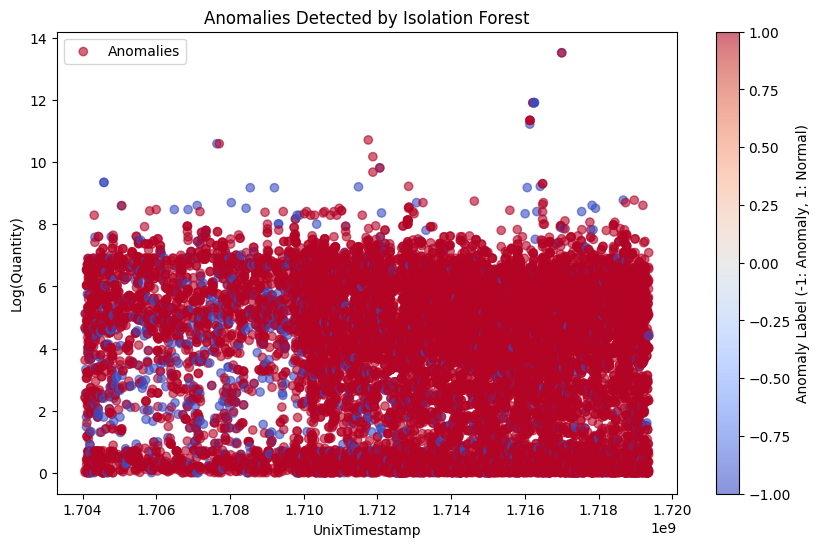

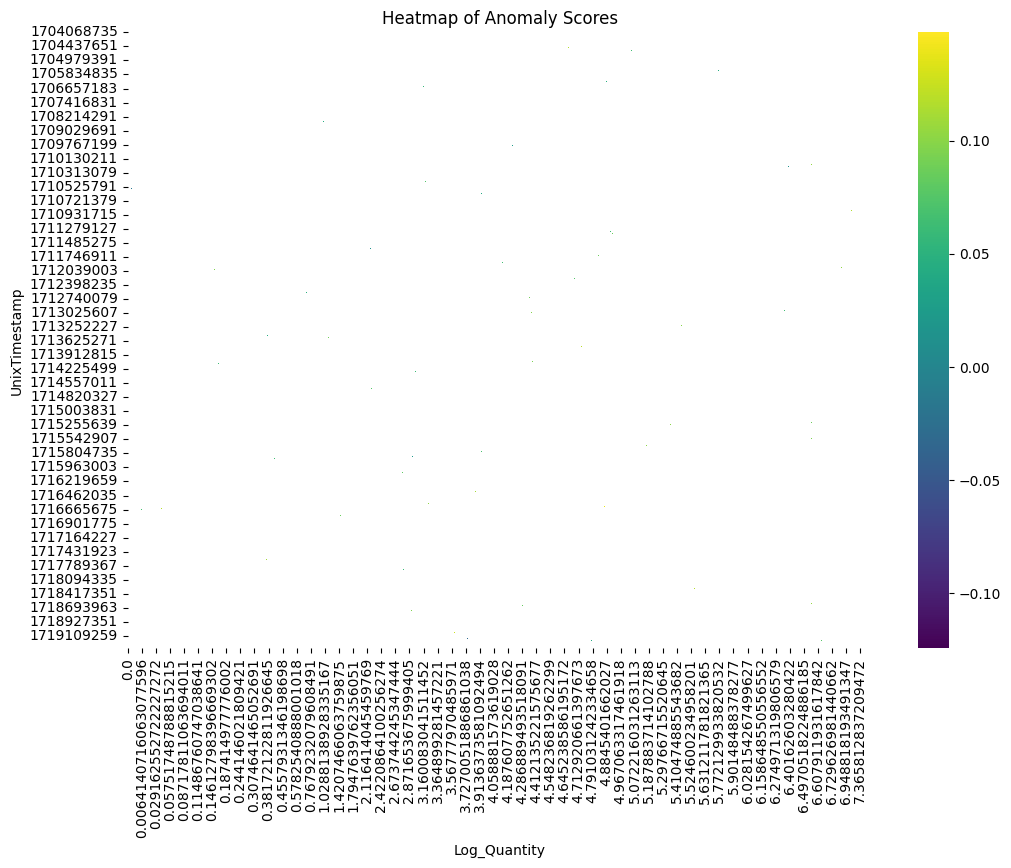

In [7]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np


# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx', sheet_name='export-token-0x85f17cf997934a59')

# Feature Engineering (as per your notebook)
data['Hour'] = pd.to_datetime(data['UnixTimestamp'], unit='s').dt.hour
data['Log_Quantity'] = np.log1p(data['Quantity'])
data['From_Transaction_Count'] = data['From'].map(data['From'].value_counts())
data['To_Transaction_Count'] = data['To'].map(data['To'].value_counts())
data['Time_Interval'] = data['UnixTimestamp'].diff().fillna(0)

# Create a directed graph from the transaction data
G = nx.DiGraph()

# Add edges to the graph with weights as Quantity
edges = data[['From', 'To', 'Quantity']].values
G.add_weighted_edges_from(edges)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

# Add these features to the original dataset
data['Degree Centrality'] = data['From'].map(degree_centrality)
data['Betweenness Centrality'] = data['From'].map(betweenness_centrality)
data['Closeness Centrality'] = data['From'].map(closeness_centrality)

# Select features for the Isolation Forest model
features = data[['Log_Quantity', 'Hour', 'From_Transaction_Count', 'To_Transaction_Count',
                 'Time_Interval','Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']]

# Handle missing values by filling with the mean
features = features.fillna(features.mean())

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Initialize and train the Isolation Forest model
n_estimators = 100
contamination = 0.05
max_samples = 'auto'
iso_forest = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            max_samples=max_samples,
                            random_state=42)
iso_forest.fit(features_scaled)

# Detect anomalies
anomaly_scores = iso_forest.decision_function(features_scaled)
labels = iso_forest.predict(features_scaled)

# Add anomaly scores and labels to the original dataset
data['Anomaly_Score'] = anomaly_scores
data['Anomaly_Label'] = labels  # -1 for anomaly, 1 for normal

# 2D Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['UnixTimestamp'], data['Log_Quantity'], c=data['Anomaly_Label'], cmap='coolwarm', label='Anomalies', alpha=0.6)
plt.title('Anomalies Detected by Isolation Forest')
plt.xlabel('UnixTimestamp')
plt.ylabel('Log(Quantity)')
plt.colorbar(label='Anomaly Label (-1: Anomaly, 1: Normal)')
plt.legend()
plt.show()

# Heatmap of anomaly scores
plt.figure(figsize=(12, 8))
heatmap_data = data[['UnixTimestamp', 'Log_Quantity', 'Anomaly_Score']]
heatmap_data = heatmap_data.pivot_table(index='UnixTimestamp', columns='Log_Quantity', values='Anomaly_Score')
sns.heatmap(heatmap_data, cmap='viridis')
plt.title('Heatmap of Anomaly Scores')
plt.show()

### **Task 5: Train Isolation Forest Model**

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx', sheet_name='export-token-0x85f17cf997934a59')

# Feature Engineering (as per your notebook)
data['Hour'] = pd.to_datetime(data['UnixTimestamp'], unit='s').dt.hour
data['Log_Quantity'] = np.log1p(data['Quantity'])
data['From_Transaction_Count'] = data['From'].map(data['From'].value_counts())
data['To_Transaction_Count'] = data['To'].map(data['To'].value_counts())
data['Time_Interval'] = data['UnixTimestamp'].diff().fillna(0)

import networkx as nx
# Create a directed graph from the transaction data
G = nx.DiGraph()

# Add edges to the graph with weights as Quantity
edges = data[['From', 'To', 'Quantity']].values
G.add_weighted_edges_from(edges)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

# Add these features to the original dataset
data['Degree Centrality'] = data['From'].map(degree_centrality)
data['Betweenness Centrality'] = data['From'].map(betweenness_centrality)
data['Closeness Centrality'] = data['From'].map(closeness_centrality)

# Select features for the Isolation Forest model
features = data[['Log_Quantity', 'Hour', 'From_Transaction_Count', 'To_Transaction_Count',
                 'Time_Interval','Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']]


# Handle missing values by filling with the mean
features = features.fillna(features.mean())

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Initialize and train the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, max_samples='auto', random_state=42)
iso_forest.fit(features_scaled)

print("Isolation Forest model trained.")

Isolation Forest model trained.


# **Local Outlier Factor(LOF)**

In [9]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import networkx as nx  # Import networkx

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx', sheet_name='export-token-0x85f17cf997934a59')

# Task 1: Clean and preprocess the dataset
# Scale numerical features and encode categorical variables

def preprocess_data(data):
    # Select numerical features
    numerical_features = ['Quantity','Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Blockno']
    scaler = MinMaxScaler()
    data[numerical_features] = scaler.fit_transform(data[numerical_features])

    # Select categorical features
    categorical_features = ['From', 'To', 'Method']
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_categories = encoder.fit_transform(data[categorical_features])
    encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(categorical_features))

    # Combine numerical and encoded categorical features
    preprocessed_data = pd.concat([data[numerical_features], encoded_df], axis=1)
    return preprocessed_data



In [10]:
# Task 2: Feature selection and/or creation
def create_features(data):
    # Calculate and add 'Betweenness Centrality' if it's not present
    if not all(col in data.columns for col in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']):
        # Create a directed graph from the transaction data
        G = nx.DiGraph()
        edges = data[['From', 'To', 'Quantity']].values
        G.add_weighted_edges_from(edges)
        # Compute centrality metrics
        betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
        # Add these features to the original dataset
        data['Betweenness Centrality'] = data['From'].map(betweenness_centrality)
        # Add other centrality metrics if they are not present
        degree_centrality = nx.degree_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        data['Degree Centrality'] = data['From'].map(degree_centrality)
        data['Closeness Centrality'] = data['From'].map(closeness_centrality)

    # Calculate TransactionFrequency and TransactionAmountRatio
    data['TransactionFrequency'] = data.groupby('From')['Quantity'].transform('count') # Fixed: Use 'Quantity' for count
    data['TransactionAmountRatio'] = data['Quantity'] / data.groupby('From')['Quantity'].transform('sum')
    return data

# Create features before preprocessing
data_with_features = create_features(data)

# Preprocess the data after feature creation
preprocessed_data = preprocess_data(data_with_features)

In [11]:
from IPython.display import display
# Create features before preprocessing
data_with_features = create_features(data)

# Preprocess the data after feature creation
preprocessed_data = preprocess_data(data_with_features)

# Display the first few rows of the updated data
display(data.head())

,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,Betweenness Centrality,Degree Centrality,Closeness Centrality,TransactionFrequency,TransactionAmountRatio
0,0x27797428fc8aaf088cc707c8788b5d13580696418c79...,0.000000,1704068735,2024-01-01 00:25:35,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x776a0725094cbf984e31b43d17e8aaec3c88294a,4.879178e-05,Sell To Uniswap,1.000000,1.000000,1.000000,2425,1.778927e-04
1,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,0.000041,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,1.399790e-04,0x415565b0,0.051332,0.113936,0.906074,3575,1.650612e-04
2,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,0.000041,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,1.053794e-07,0x415565b0,0.051332,0.113936,0.906074,3575,1.242619e-07
3,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,0.000041,1704069371,2024-01-01 00:36:11,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0xd98d9d8c5a70df5d5d8e39847ce254347a59816b,1.399790e-04,0x415565b0,0.450616,0.778719,0.891285,1656,3.391440e-04
4,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,0.000104,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,1.366325e-05,0x415565b0,0.051332,0.113936,0.906074,3575,1.611150e-05


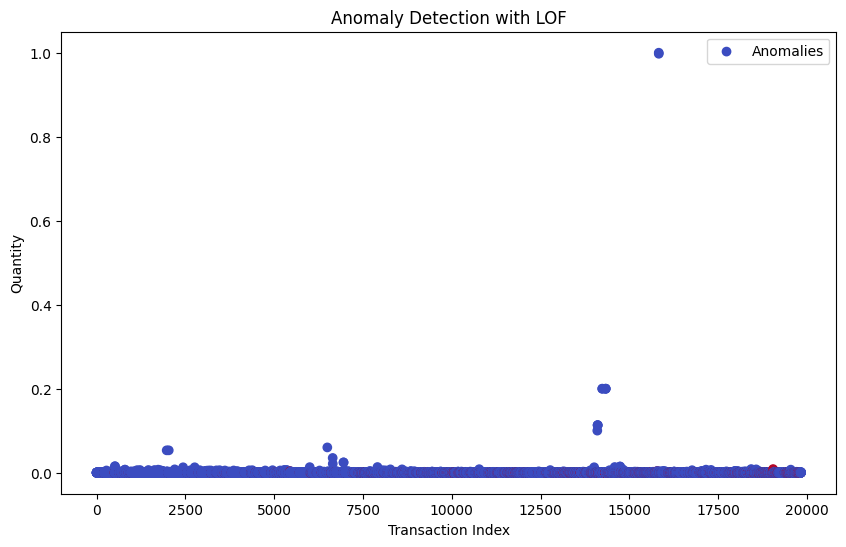

In [12]:
# Task 3: Initialize and train the Local Outlier Factor (LOF) model
# Select relevant features for LOF
relevant_features = preprocessed_data.columns
X = preprocessed_data[relevant_features]

# Train the LOF model
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
preprocessed_data['AnomalyScore'] = lof_model.fit_predict(X)
preprocessed_data['AnomalyScore'] = np.where(preprocessed_data['AnomalyScore'] == -1, 1, 0)  # 1 for anomaly, 0 for normal
import os

# Before saving the file, create the directory if it doesn't exist:
os.makedirs('/content/data', exist_ok=True)

# Save the results to a CSV file
preprocessed_data.to_csv('/content/data/lof_anomaly_detection_results.csv', index=False)

# Visualize anomalies
plt.figure(figsize=(10, 6))
plt.scatter(preprocessed_data.index, preprocessed_data['Quantity'], c=preprocessed_data['AnomalyScore'], cmap='coolwarm', label='Anomalies')
plt.title('Anomaly Detection with LOF')
plt.xlabel('Transaction Index')
plt.ylabel('Quantity')
plt.legend()
plt.savefig('/content/data/lof_anomaly_detection_visualization.png')
plt.show()

In [14]:
# Step 1: Select relevant features

data = pd.read_excel('../../Data/transaction.xlsx')
data.head()

X = data[['Quantity']].copy()

# Step 2: Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train the LOF model
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # 10% of data as anomalies
y_pred = lof.fit_predict(X_scaled)

# Add the LOF scores and labels to the dataset
data['LOF_Score'] = lof.negative_outlier_factor_
data['Outlier_Label'] = y_pred  # -1 = anomalous, 1 = normal

# Step 4: Display anomalies
anomalies = data[data['Outlier_Label'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")
anomalies


Number of anomalies detected: 1983


,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,LOF_Score,Outlier_Label
15,0xc6345ad2ad66de57317228d943b8f2cc8bb248f29c2e...,18912192,1704107327,2024-01-01 11:08:47,0xbd49e0f383f501001d97358b8e4f8dca788fa41a,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,19.948396,0x415565b0,-3.160065e+00,-1
16,0xc6345ad2ad66de57317228d943b8f2cc8bb248f29c2e...,18912192,1704107327,2024-01-01 11:08:47,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0x6469b34a2a4723163c4902dbbdea728d20693c12,19.948396,0x415565b0,-3.160065e+00,-1
26,0x9a57adfe813708c9180b14dabcc08ab1dcc55505d7fe...,18912669,1704113195,2024-01-01 12:46:35,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x6469b34a2a4723163c4902dbbdea728d20693c12,701.284301,-,-9.521530e+05,-1
36,0x95910d734c548e7c25071c772461712be8093bec9014...,18913377,1704121787,2024-01-01 15:09:47,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.001672,0x415565b0,-1.218440e+00,-1
46,0xc31ccac2c0d0f978e761d4aaa8e26ab58a460cceeb23...,18914386,1704133967,2024-01-01 18:32:47,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x1c742eed25fdd98588de2263b0914565fb4d7d04,100.202766,Sell To Uniswap,-3.217620e+04,-1
...,...,...,...,...,...,...,...,...,...,...
19779,0x1c98a86dd290182dfffc86d3f714bb3b067cda74a57a...,20169062,1719322919,2024-06-25 13:41:59,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0x9d8c87be2e2109817e9a754435a42ad646c69d6b,13.808331,0x415565b0,-1.209564e+00,-1
19796,0x36752947a59371c2e7445d74fc9d69be00b1151dc39e...,20169989,1719334067,2024-06-25 16:47:47,0xee8aaa362a75fbf8e0a38a50ddc27f38551e16ea,0x1111111254eeb25477b68fb85ed929f73a960582,17.557069,Swap,-1.187513e+00,-1
19797,0x36752947a59371c2e7445d74fc9d69be00b1151dc39e...,20169989,1719334067,2024-06-25 16:47:47,0x1111111254eeb25477b68fb85ed929f73a960582,0x4a41f0e8560fa6b2d4737bc62db7fd9a250e182a,17.557069,Swap,-1.187513e+00,-1
19818,0x4a613ed0b5baae590ca416aa3f280167aa0ccf7b6b12...,20171387,1719350963,2024-06-25 21:29:23,0x5f515f6c524b18ca30f7783fb58dd4be2e9904ec,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,283.594000,Swap,-1.259596e+00,-1


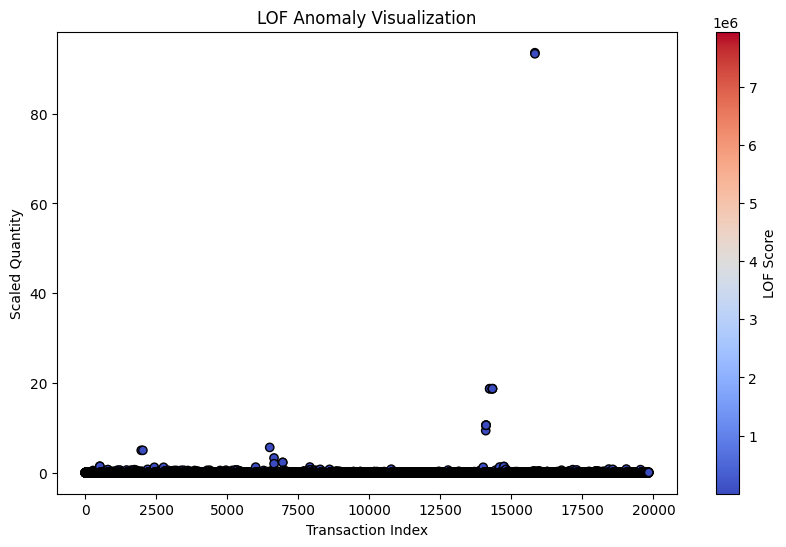

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #Import StandardScaler

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx')

# Step 1: Select relevant features
X = data[['Quantity']].copy()

# Step 2: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train the LOF model
from sklearn.neighbors import LocalOutlierFactor
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Calculate LOF scores
lof_model.fit(X_scaled)  # Fit the model to your data before getting outlier scores
lof_scores = -lof_model.negative_outlier_factor_  # Get LOF scores


# Now you can plot - Scatter plot of transaction index vs scaled quantity colored by LOF Score
plt.figure(figsize=(10, 6))
plt.scatter(X.index, X_scaled, c=lof_scores, cmap='coolwarm', edgecolor='k')
plt.colorbar(label="LOF Score")
plt.title("LOF Anomaly Visualization")
plt.xlabel("Transaction Index")
plt.ylabel("Scaled Quantity")
plt.show()

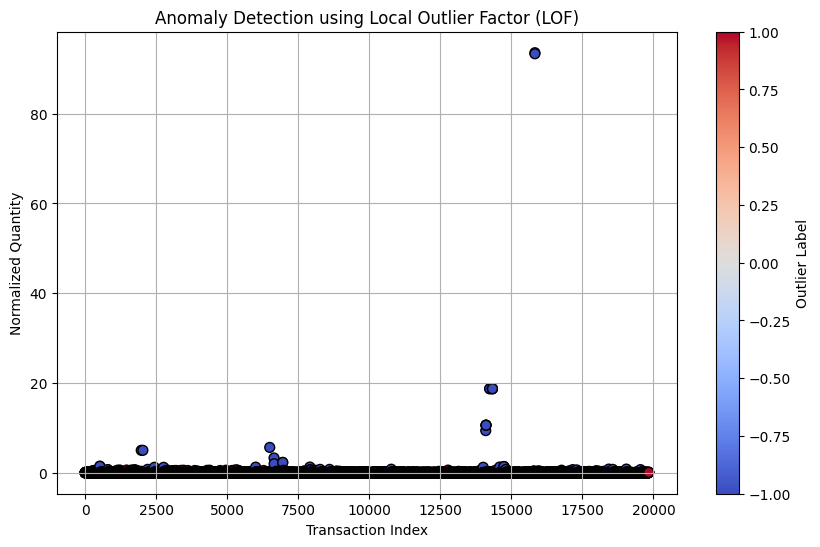

In [16]:
import matplotlib.pyplot as plt

# Prepare the data for visualization
X['Outlier_Label'] = y_pred  # Add labels for normal (1) and anomalous (-1)

# Plot the data points
plt.figure(figsize=(10, 6))
plt.scatter(X.index, X_scaled, c=y_pred, cmap='coolwarm', edgecolor='k', s=50)

# Highlight anomalies
plt.title('Anomaly Detection using Local Outlier Factor (LOF)')
plt.xlabel('Transaction Index')
plt.ylabel('Normalized Quantity')
plt.colorbar(label='Outlier Label')
plt.grid(True)
plt.show()


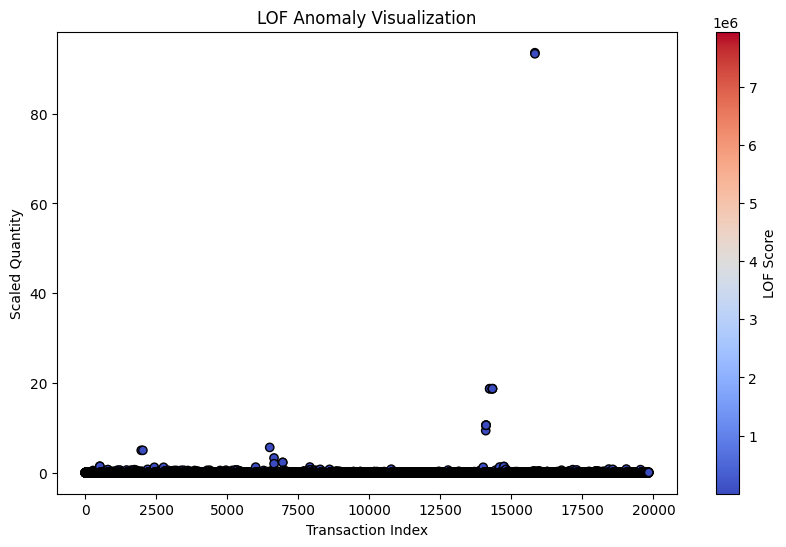

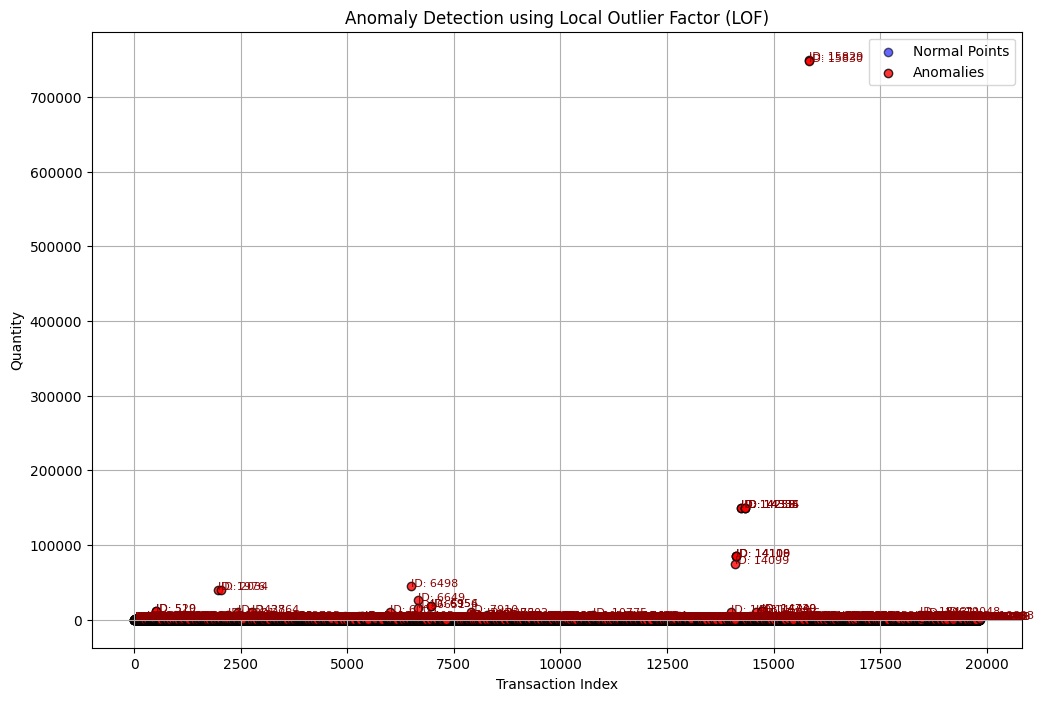

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler #Import StandardScaler

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx')

# Step 1: Select relevant features
X = data[['Quantity']].copy()

# Step 2: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train the LOF model
from sklearn.neighbors import LocalOutlierFactor
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Calculate LOF scores
lof_model.fit(X_scaled)  # Fit the model to your data before getting outlier scores
lof_scores = -lof_model.negative_outlier_factor_  # Get LOF scores

# Add LOF labels to the dataset
y_pred = lof_model.fit_predict(X_scaled)
data['Outlier_Label'] = y_pred  # -1 = anomalous, 1 = normal

# Now you can plot - Scatter plot of transaction index vs scaled quantity colored by LOF Score
plt.figure(figsize=(10, 6))
plt.scatter(X.index, X_scaled, c=lof_scores, cmap='coolwarm', edgecolor='k')
plt.colorbar(label="LOF Score")
plt.title("LOF Anomaly Visualization")
plt.xlabel("Transaction Index")
plt.ylabel("Scaled Quantity")
plt.show()


# Prepare the data for visualization
data['Index'] = range(len(data))  # Add an index column for easy referencing
normal_points = data[data['Outlier_Label'] == 1]
anomalies = data[data['Outlier_Label'] == -1]

# Plot normal points
plt.figure(figsize=(12, 8))
plt.scatter(
    normal_points['Index'],
    normal_points['Quantity'],
    c='blue',
    label='Normal Points',
    alpha=0.6,
    edgecolor='k'
)

# Plot anomalous points
plt.scatter(
    anomalies['Index'],
    anomalies['Quantity'],
    c='red',
    label='Anomalies',
    alpha=0.8,
    edgecolor='k'
)

# Annotate anomalies
for _, row in anomalies.iterrows():
    plt.text(
        row['Index'],
        row['Quantity'],
        f"ID: {int(row['Index'])}",
        fontsize=8,
        color='darkred'
    )

# Add plot details
plt.title('Anomaly Detection using Local Outlier Factor (LOF)')
plt.xlabel('Transaction Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import pandas as pd

data.head()


,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,Index
0,0x27797428fc8aaf088cc707c8788b5d13580696418c79...,18909018,1704068735,2024-01-01 00:25:35,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x776a0725094cbf984e31b43d17e8aaec3c88294a,36.593837,Sell To Uniswap,0
1,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,104.984275,0x415565b0,1
2,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.079035,0x415565b0,2
3,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0xd98d9d8c5a70df5d5d8e39847ce254347a59816b,104.984275,0x415565b0,3
4,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,18909149,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,10.247435,0x415565b0,4


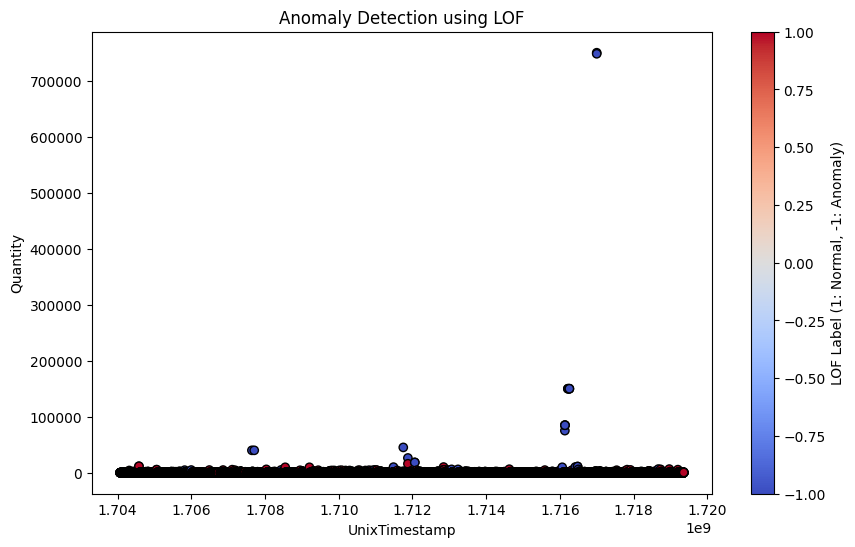

In [27]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx  # Import networkx

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx')


# Create a directed graph from the transaction data
G = nx.DiGraph()
edges = data[['From', 'To', 'Quantity']].values
G.add_weighted_edges_from(edges)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

# Add these features to the original dataset
data['Degree Centrality'] = data['From'].map(degree_centrality)
data['Betweenness Centrality'] = data['From'].map(betweenness_centrality)
data['Closeness Centrality'] = data['From'].map(closeness_centrality)

# Select relevant features for LOF analysis
# Include 'UnixTimestamp' here
features = data[['Quantity', 'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'UnixTimestamp']].copy()

# Handle any missing or non-numerical values (if any)
features = features.dropna()
features = features.astype(float)

# Apply the Local Outlier Factor (LOF) model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
labels = lof.fit_predict(features)
scores = lof.negative_outlier_factor_

# Add the labels to the dataset
features['LOF Label'] = labels

# Plot the data points with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.scatter(features['UnixTimestamp'], features['Quantity'], c=features['LOF Label'], cmap='coolwarm', edgecolor='k')
plt.title('Anomaly Detection using LOF')
plt.xlabel('UnixTimestamp')
plt.ylabel('Quantity')
plt.colorbar(label='LOF Label (1: Normal, -1: Anomaly)')
plt.show()

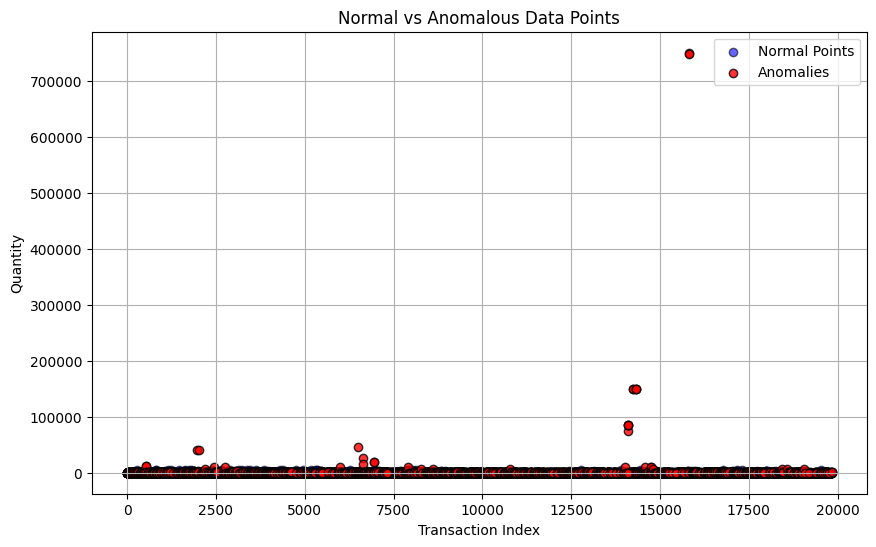

In [24]:
import matplotlib.pyplot as plt

# Split data into normal and anomalous points
normal_points = data[data['Outlier_Label'] == 1]
anomalies = data[data['Outlier_Label'] == -1]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(normal_points.index, normal_points['Quantity'], c='blue', label='Normal Points', alpha=0.6, edgecolor='k')
plt.scatter(anomalies.index, anomalies['Quantity'], c='red', label='Anomalies', alpha=0.8, edgecolor='k')

# Plot details
plt.title('Normal vs Anomalous Data Points')
plt.xlabel('Transaction Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Step 1: Select relevant feature(s)
X = data[['Quantity']]  # Focus on the 'Quantity' column for LOF training

# Step 2: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # 10% data considered as anomalies
y_pred = lof.fit_predict(X_scaled)

# Add LOF scores and labels to the dataset
data['LOF_Score'] = lof.negative_outlier_factor_
data['Outlier_Label'] = y_pred  # -1 = anomaly, 1 = normal

# Output results
print(f"Number of anomalies detected: {(data['Outlier_Label'] == -1).sum()}")
data.head()


Number of anomalies detected: 1983


,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,Degree Centrality,Betweenness Centrality,Closeness Centrality,LOF_Score,Outlier_Label
0,0x27797428fc8aaf088cc707c8788b5d13580696418c79...,18909018,1704068735,2024-01-01 00:25:35,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x776a0725094cbf984e31b43d17e8aaec3c88294a,36.593837,Sell To Uniswap,0.302418,0.373287,0.234901,-0.980022,1
1,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,104.984275,0x415565b0,0.034708,0.019162,0.212838,-1.006338,1
2,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.079035,0x415565b0,0.034708,0.019162,0.212838,-1.120186,1
3,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0xd98d9d8c5a70df5d5d8e39847ce254347a59816b,104.984275,0x415565b0,0.235562,0.168209,0.209364,-1.006338,1
4,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,18909149,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,10.247435,0x415565b0,0.034708,0.019162,0.212838,-1.150175,1


In [29]:
# Count anomalies and normal points
num_anomalies = (data['Outlier_Label'] == -1).sum()
num_normal = (data['Outlier_Label'] == 1).sum()

print(f"Number of anomalies detected: {num_anomalies}")
print(f"Number of normal points: {num_normal}")

# Display top anomalies with the lowest LOF scores
top_anomalies = data[data['Outlier_Label'] == -1].sort_values(by='LOF_Score')
print("Top anomalies based on LOF Score:")
print(top_anomalies[['Quantity', 'LOF_Score']].head())


Number of anomalies detected: 1983
Number of normal points: 17853
Top anomalies based on LOF Score:
          Quantity     LOF_Score
422    1213.678514 -7.944585e+06
423    1213.678514 -7.944585e+06
11704  1212.271666 -7.549267e+06
5416   1206.000000 -7.017897e+06
473    1011.504660 -4.426078e+06


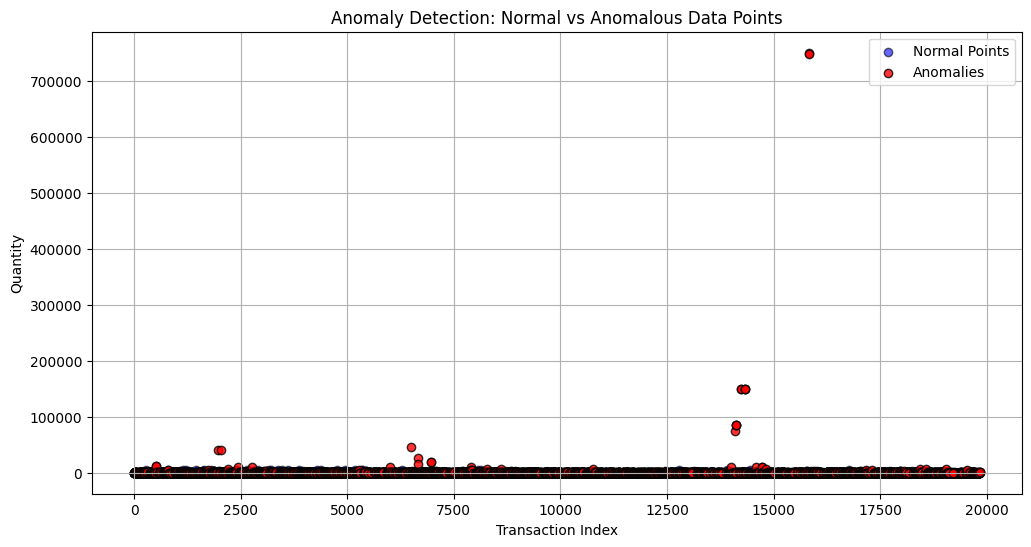

In [30]:
import matplotlib.pyplot as plt

# Split data into normal and anomalous points
normal_points = data[data['Outlier_Label'] == 1]
anomalies = data[data['Outlier_Label'] == -1]

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(normal_points.index, normal_points['Quantity'], c='blue', label='Normal Points', alpha=0.6, edgecolor='k')
plt.scatter(anomalies.index, anomalies['Quantity'], c='red', label='Anomalies', alpha=0.8, edgecolor='k')

# Plot details
plt.title('Anomaly Detection: Normal vs Anomalous Data Points')
plt.xlabel('Transaction Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()


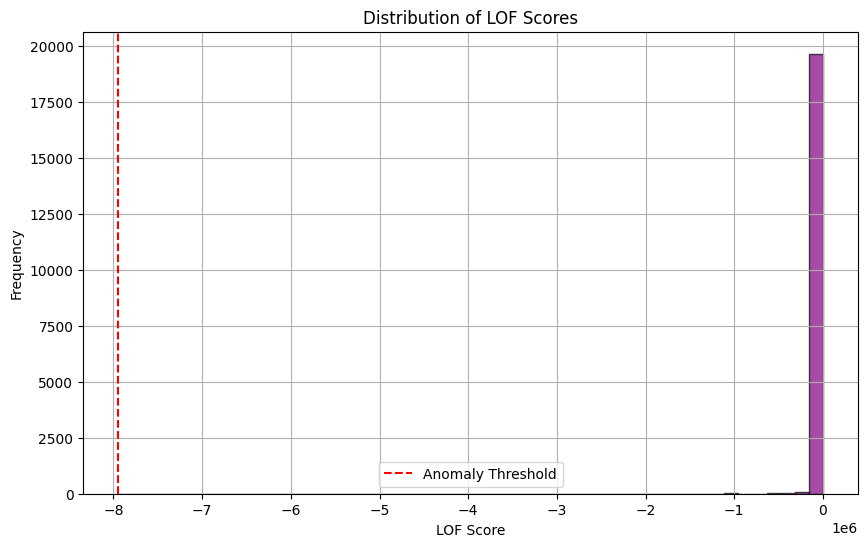

In [31]:
# Histogram of LOF Scores
plt.figure(figsize=(10, 6))
plt.hist(data['LOF_Score'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.title('Distribution of LOF Scores')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.axvline(x=min(data['LOF_Score']), color='red', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Step 1: Select relevant feature(s)
X = data[['Quantity']]  # Focus on the 'Quantity' column for LOF training

# Step 2: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # 10% data considered as anomalies
y_pred = lof.fit_predict(X_scaled)

# Add LOF scores and labels to the dataset
data['LOF_Score'] = lof.negative_outlier_factor_
data['Outlier_Label'] = y_pred  # -1 = anomaly, 1 = normal

# Output results
print(f"Number of anomalies detected: {(data['Outlier_Label'] == -1).sum()}")
data.head()


Number of anomalies detected: 1983


,Transaction Hash,Blockno,UnixTimestamp,DateTime (UTC),From,To,Quantity,Method,Degree Centrality,Betweenness Centrality,Closeness Centrality,LOF_Score,Outlier_Label
0,0x27797428fc8aaf088cc707c8788b5d13580696418c79...,18909018,1704068735,2024-01-01 00:25:35,0x6469b34a2a4723163c4902dbbdea728d20693c12,0x776a0725094cbf984e31b43d17e8aaec3c88294a,36.593837,Sell To Uniswap,0.302418,0.373287,0.234901,-0.980022,1
1,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,104.984275,0x415565b0,0.034708,0.019162,0.212838,-1.006338,1
2,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x95c4f5b83aa70810d4f142d58e5f7242bd891cb0,0.079035,0x415565b0,0.034708,0.019162,0.212838,-1.120186,1
3,0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...,18909070,1704069371,2024-01-01 00:36:11,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,0xd98d9d8c5a70df5d5d8e39847ce254347a59816b,104.984275,0x415565b0,0.235562,0.168209,0.209364,-1.006338,1
4,0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...,18909149,1704070319,2024-01-01 00:51:59,0x983dfba1c0724786598af0e63a9a6f94aabd24a1,0x22f9dcf4647084d6c31b2765f6910cd85c178c18,10.247435,0x415565b0,0.034708,0.019162,0.212838,-1.150175,1


In [33]:
# Count anomalies and normal points
num_anomalies = (data['Outlier_Label'] == -1).sum()
num_normal = (data['Outlier_Label'] == 1).sum()

print(f"Number of anomalies detected: {num_anomalies}")
print(f"Number of normal points: {num_normal}")

# Display top anomalies with the lowest LOF scores
top_anomalies = data[data['Outlier_Label'] == -1].sort_values(by='LOF_Score')
print("Top anomalies based on LOF Score:")
print(top_anomalies[['Quantity', 'LOF_Score']].head())


Number of anomalies detected: 1983
Number of normal points: 17853
Top anomalies based on LOF Score:
          Quantity     LOF_Score
422    1213.678514 -7.944585e+06
423    1213.678514 -7.944585e+06
11704  1212.271666 -7.549267e+06
5416   1206.000000 -7.017897e+06
473    1011.504660 -4.426078e+06


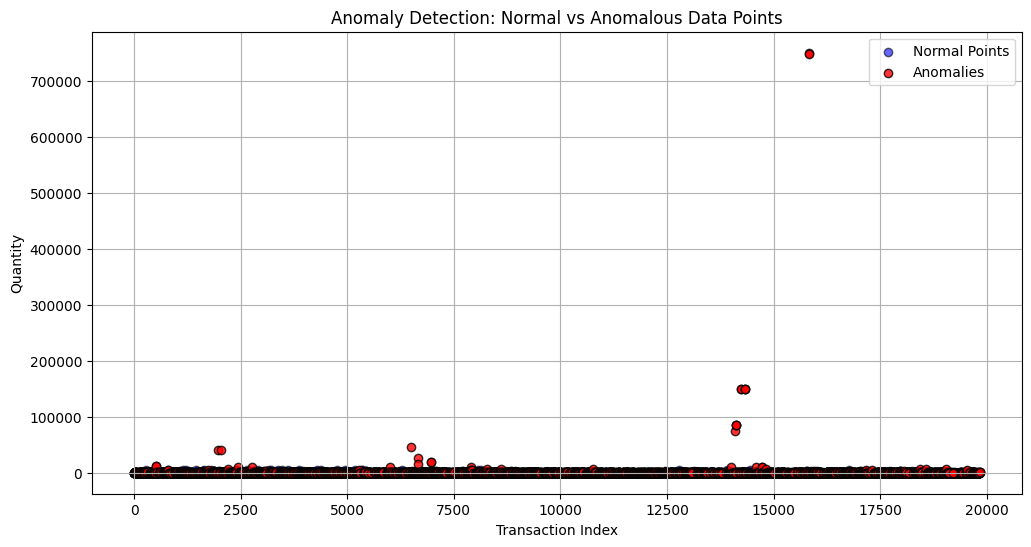

In [34]:
import matplotlib.pyplot as plt

# Split data into normal and anomalous points
normal_points = data[data['Outlier_Label'] == 1]
anomalies = data[data['Outlier_Label'] == -1]

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(normal_points.index, normal_points['Quantity'], c='blue', label='Normal Points', alpha=0.6, edgecolor='k')
plt.scatter(anomalies.index, anomalies['Quantity'], c='red', label='Anomalies', alpha=0.8, edgecolor='k')

# Plot details
plt.title('Anomaly Detection: Normal vs Anomalous Data Points')
plt.xlabel('Transaction Index')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()


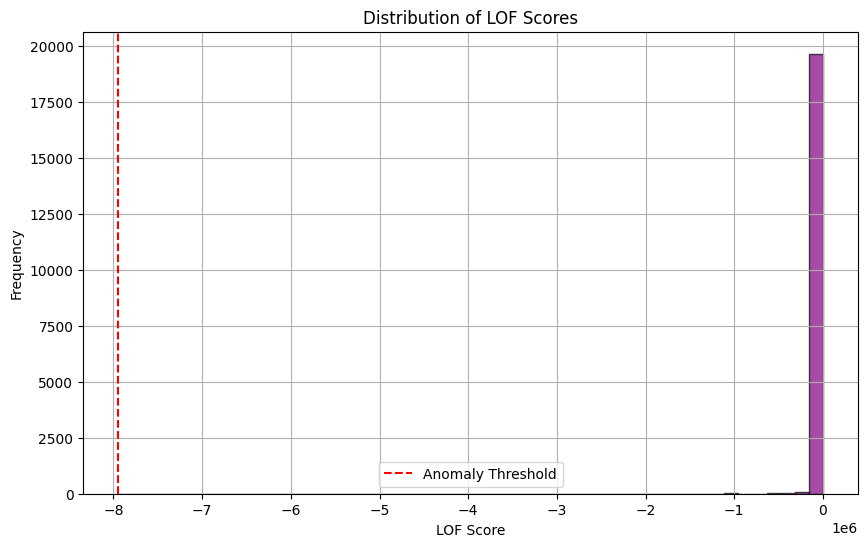

In [35]:
# Histogram of LOF Scores
plt.figure(figsize=(10, 6))
plt.hist(data['LOF_Score'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.title('Distribution of LOF Scores')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.axvline(x=min(data['LOF_Score']), color='red', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.grid(True)
plt.show()


# DBSCAN

In [37]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load the dataset (replace with your actual dataset path if needed)
data_path = '../../Data/transaction.xlsx'
data = pd.read_excel(data_path)
import networkx as nx
# Assuming 'data' has 'From' and 'To' columns for transactions
G = nx.from_pandas_edgelist(data, source='From', target='To', create_using=nx.DiGraph())

In [38]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
data['Degree Centrality'] = data['From'].map(degree_centrality)
data['Betweenness Centrality'] = data['From'].map(betweenness_centrality)
data['Closeness Centrality'] = data['From'].map(closeness_centrality)

# Select numerical columns, including centrality measures, for standardization
numerical_data = data[['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', *data.select_dtypes(include=[np.number]).columns]]
# Replace *data.select_dtypes(include=[np.number]).columns with other numerical columns if needed
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)
# Preprocess the data: Select numerical columns and standardize them
numerical_data = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

In [39]:
# Function to evaluate DBSCAN clustering
def evaluate_dbscan(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    # Only calculate silhouette score if there are more than one cluster
    if len(set(labels)) > 1 and -1 not in set(labels):
        score = silhouette_score(data, labels)
    else:
        score = -1  # Assign a low score if clustering isn't valid
    return score, labels

# Parameters for random search
num_random_samples = 20
eps_values = np.linspace(0.1, 5, 50)  # Random range for eps
min_samples_values = np.arange(2, 20)  # Random range for min_samples

# Lists to store results
results = []

In [42]:
# Perform random search
for _ in range(num_random_samples):
    eps = np.random.choice(eps_values)
    min_samples = np.random.choice(min_samples_values)
    score, labels = evaluate_dbscan(scaled_data, eps, min_samples)
    results.append((eps, min_samples, score))

# Sort results by silhouette score in descending order
results = sorted(results, key=lambda x: x[2], reverse=True)
best_eps, best_min_samples, best_score = results[0]

# Print the best parameters and their scores
print(f"Best Parameters: eps={best_eps}, min_samples={best_min_samples}, silhouette_score={best_score}")

# Print the top 5 parameters
print("Top 5 Results:")
for result in results[:5]:
    print(f"eps={result[0]}, min_samples={result[1]}, silhouette_score={result[2]}")

# Extract data for 3D scatter plot (select the first 3 columns for visualization)
data_3d = scaled_data[:, :3]


Best Parameters: eps=4.3999999999999995, min_samples=2, silhouette_score=0.8494037616411012
Top 5 Results:
eps=4.3999999999999995, min_samples=2, silhouette_score=0.8494037616411012
eps=2.5000000000000004, min_samples=2, silhouette_score=0.7371441280659125
eps=3.5000000000000004, min_samples=2, silhouette_score=0.7371441280659125
eps=1.7000000000000002, min_samples=9, silhouette_score=-1
eps=0.2, min_samples=6, silhouette_score=-1


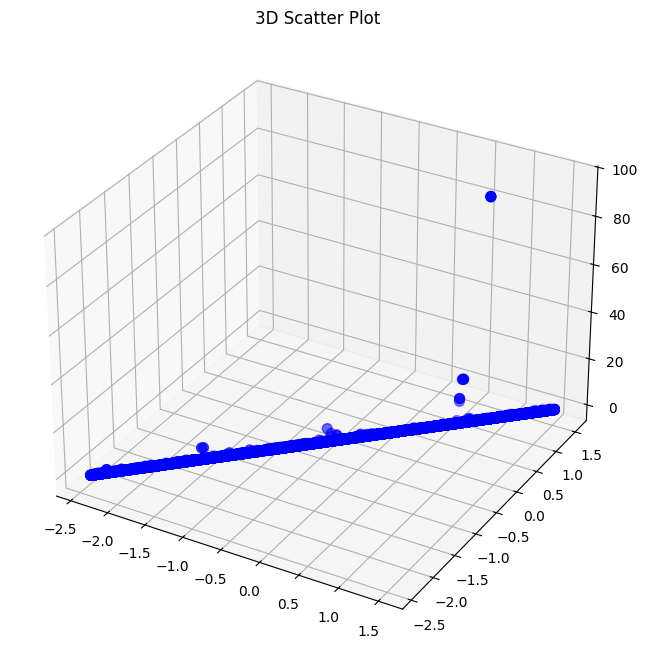

In [41]:
# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c='blue', s=50)
ax.set_title('3D Scatter Plot')
plt.show()

# Applying DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
data['Cluster'] = dbscan.fit_predict(scaled_data)

# Identifying anomalies (outliers are labeled as -1)
data['Anomaly'] = (data['Cluster'] == -1).astype(int)

Silhouette Score for the clustering: 0.8494037616411012


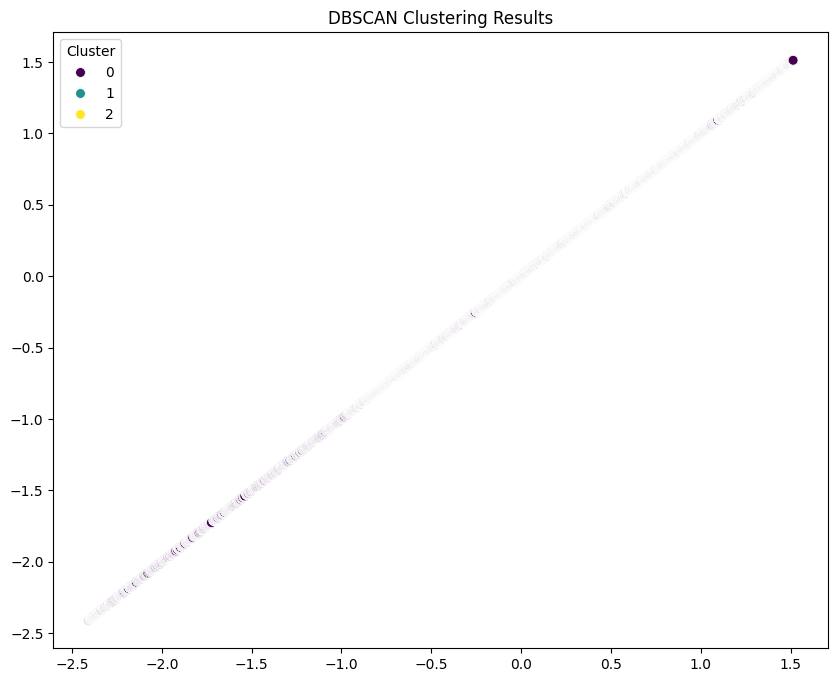

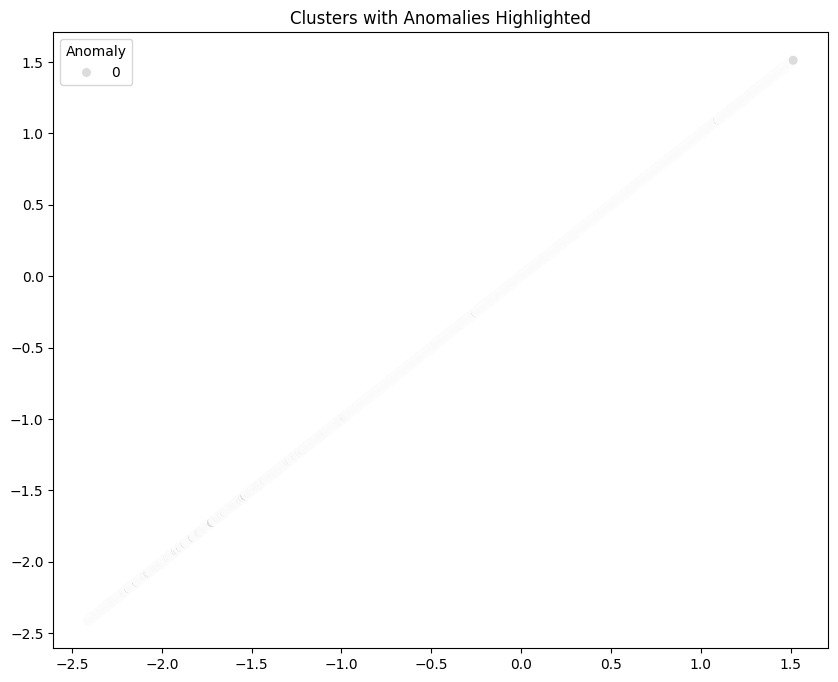

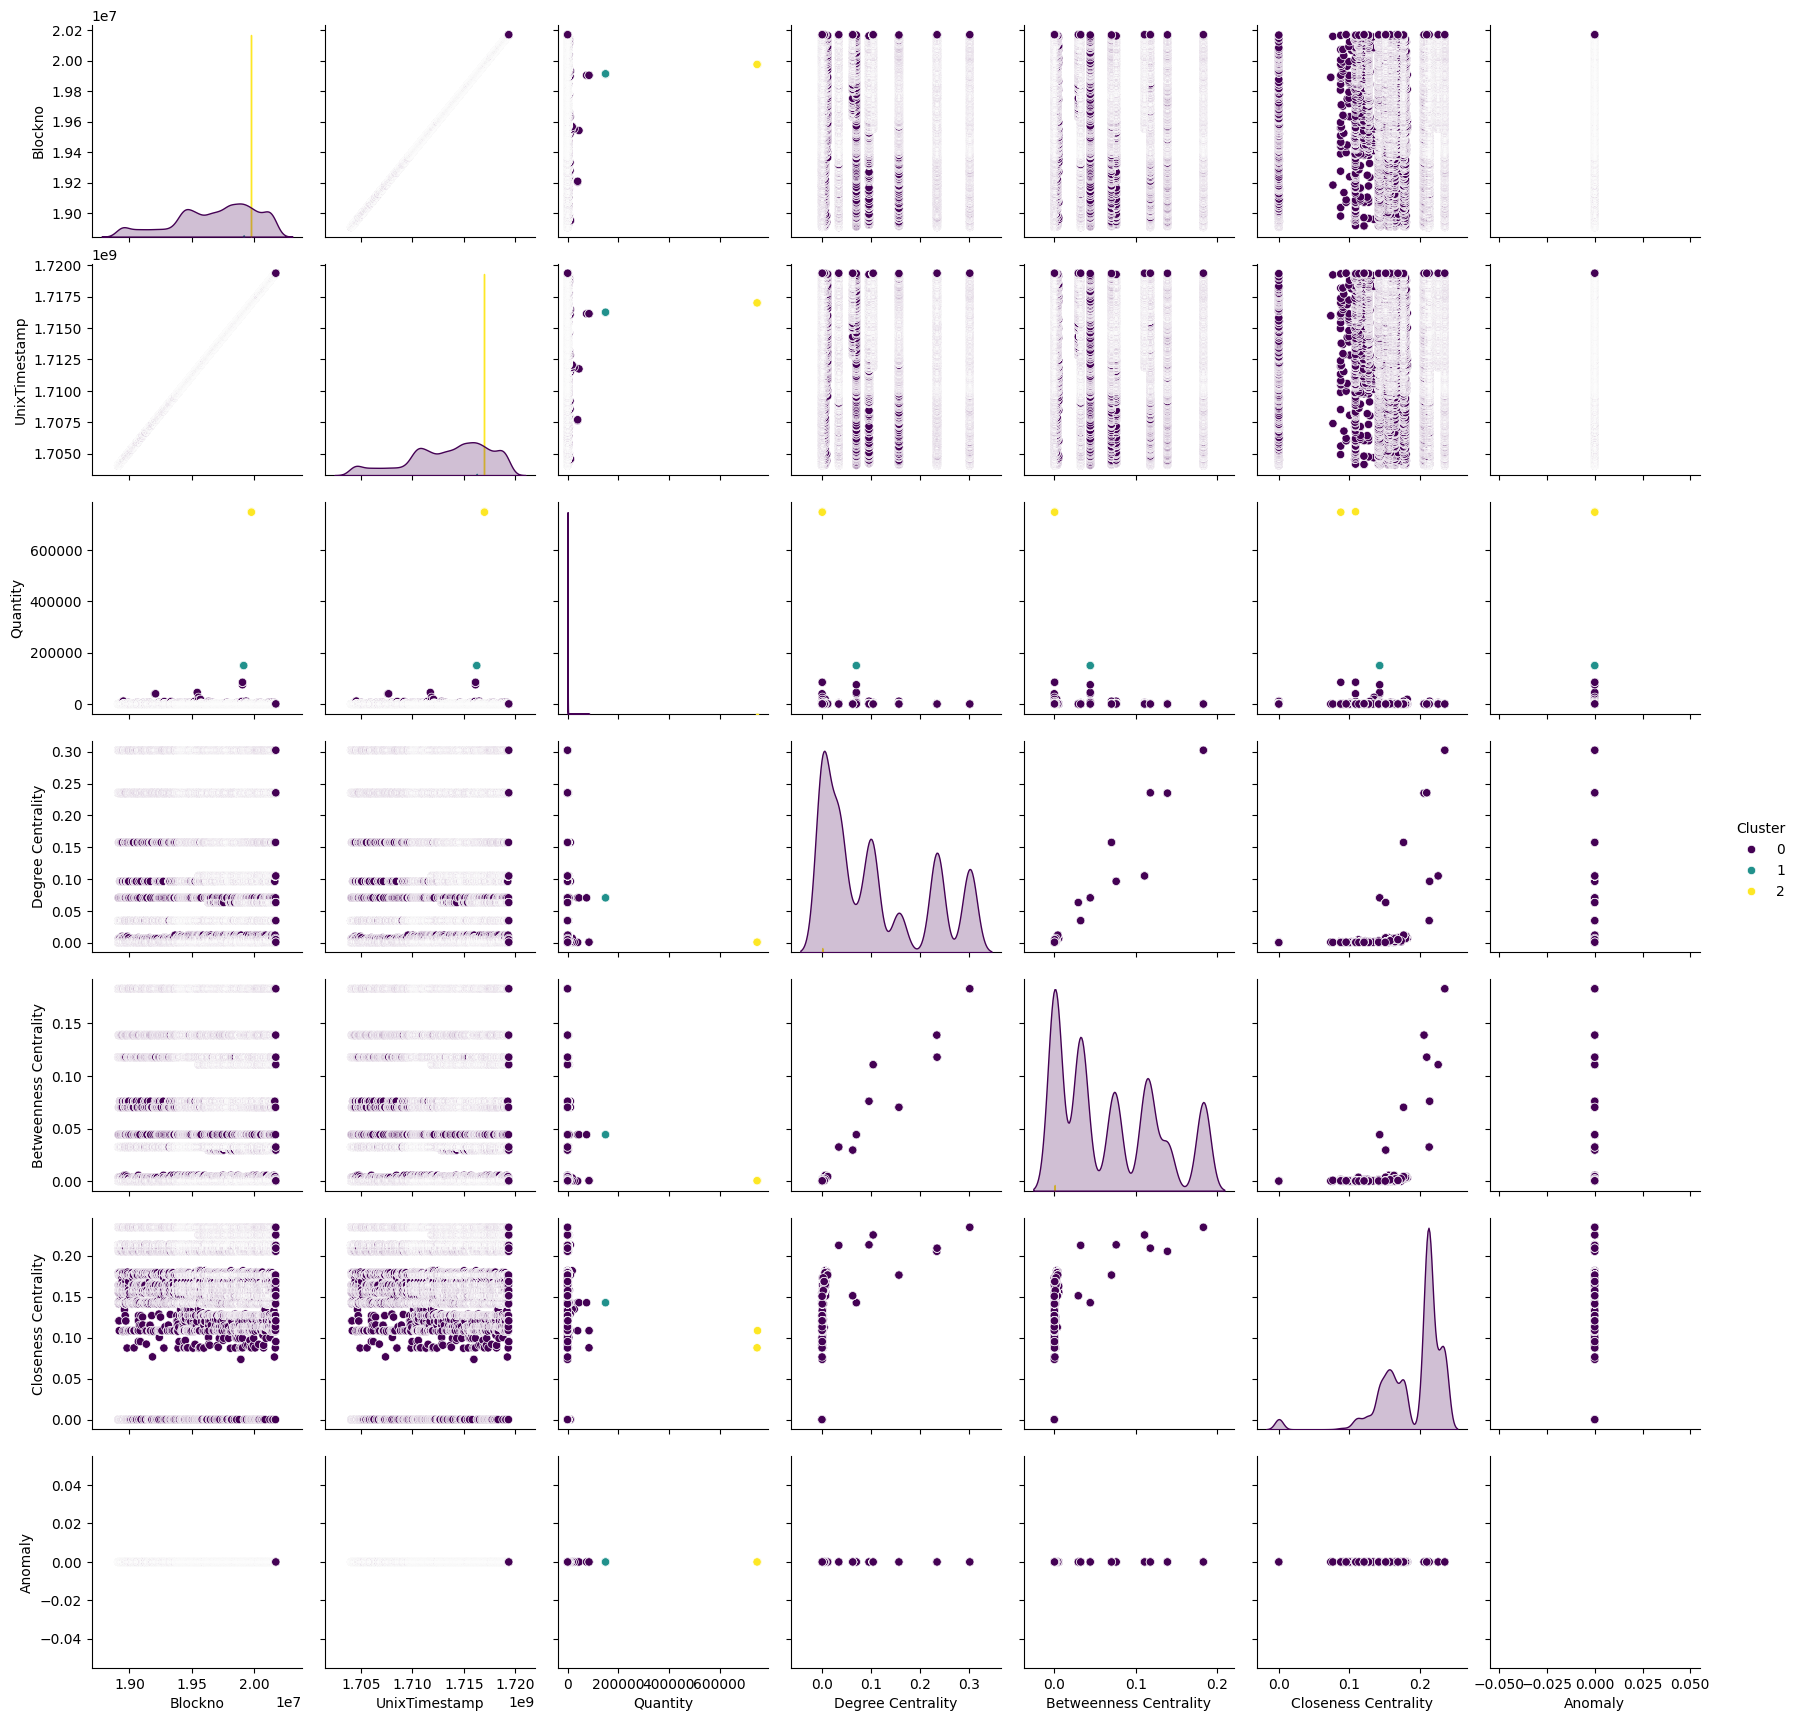

In [43]:


# Silhouette score for the clustering
labels = data['Cluster']
if len(set(labels)) > 1 and -1 not in set(labels):
    silhouette_avg = silhouette_score(scaled_data, labels)
    print(f"Silhouette Score for the clustering: {silhouette_avg}")
else:
    print("Silhouette Score could not be calculated due to invalid clustering.")

# Visualize DBSCAN results with improved color palette
plt.figure(figsize=(10, 8))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=data['Cluster'], palette='viridis', s=50)
plt.title('DBSCAN Clustering Results')
plt.show()

# Visualize clusters with anomalies highlighted
plt.figure(figsize=(10, 8))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=data['Anomaly'], palette='coolwarm', s=50)
plt.title('Clusters with Anomalies Highlighted')
plt.show()

# Pair plot to visualize relationships
sns.pairplot(data, hue='Cluster', palette='viridis')
plt.show()


# DBSCAN AND LOF COMBINE

Best Parameters: eps=0.4, min_samples=7, lof_neighbors=17
Number of outliers found: 29
Adjusted Rand Index (ARI): 0.02315388290676368


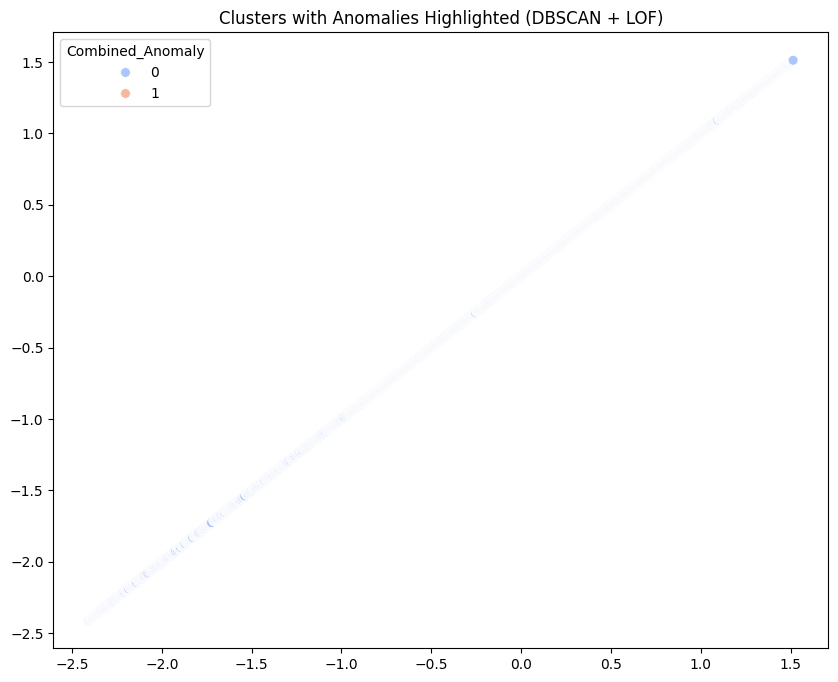

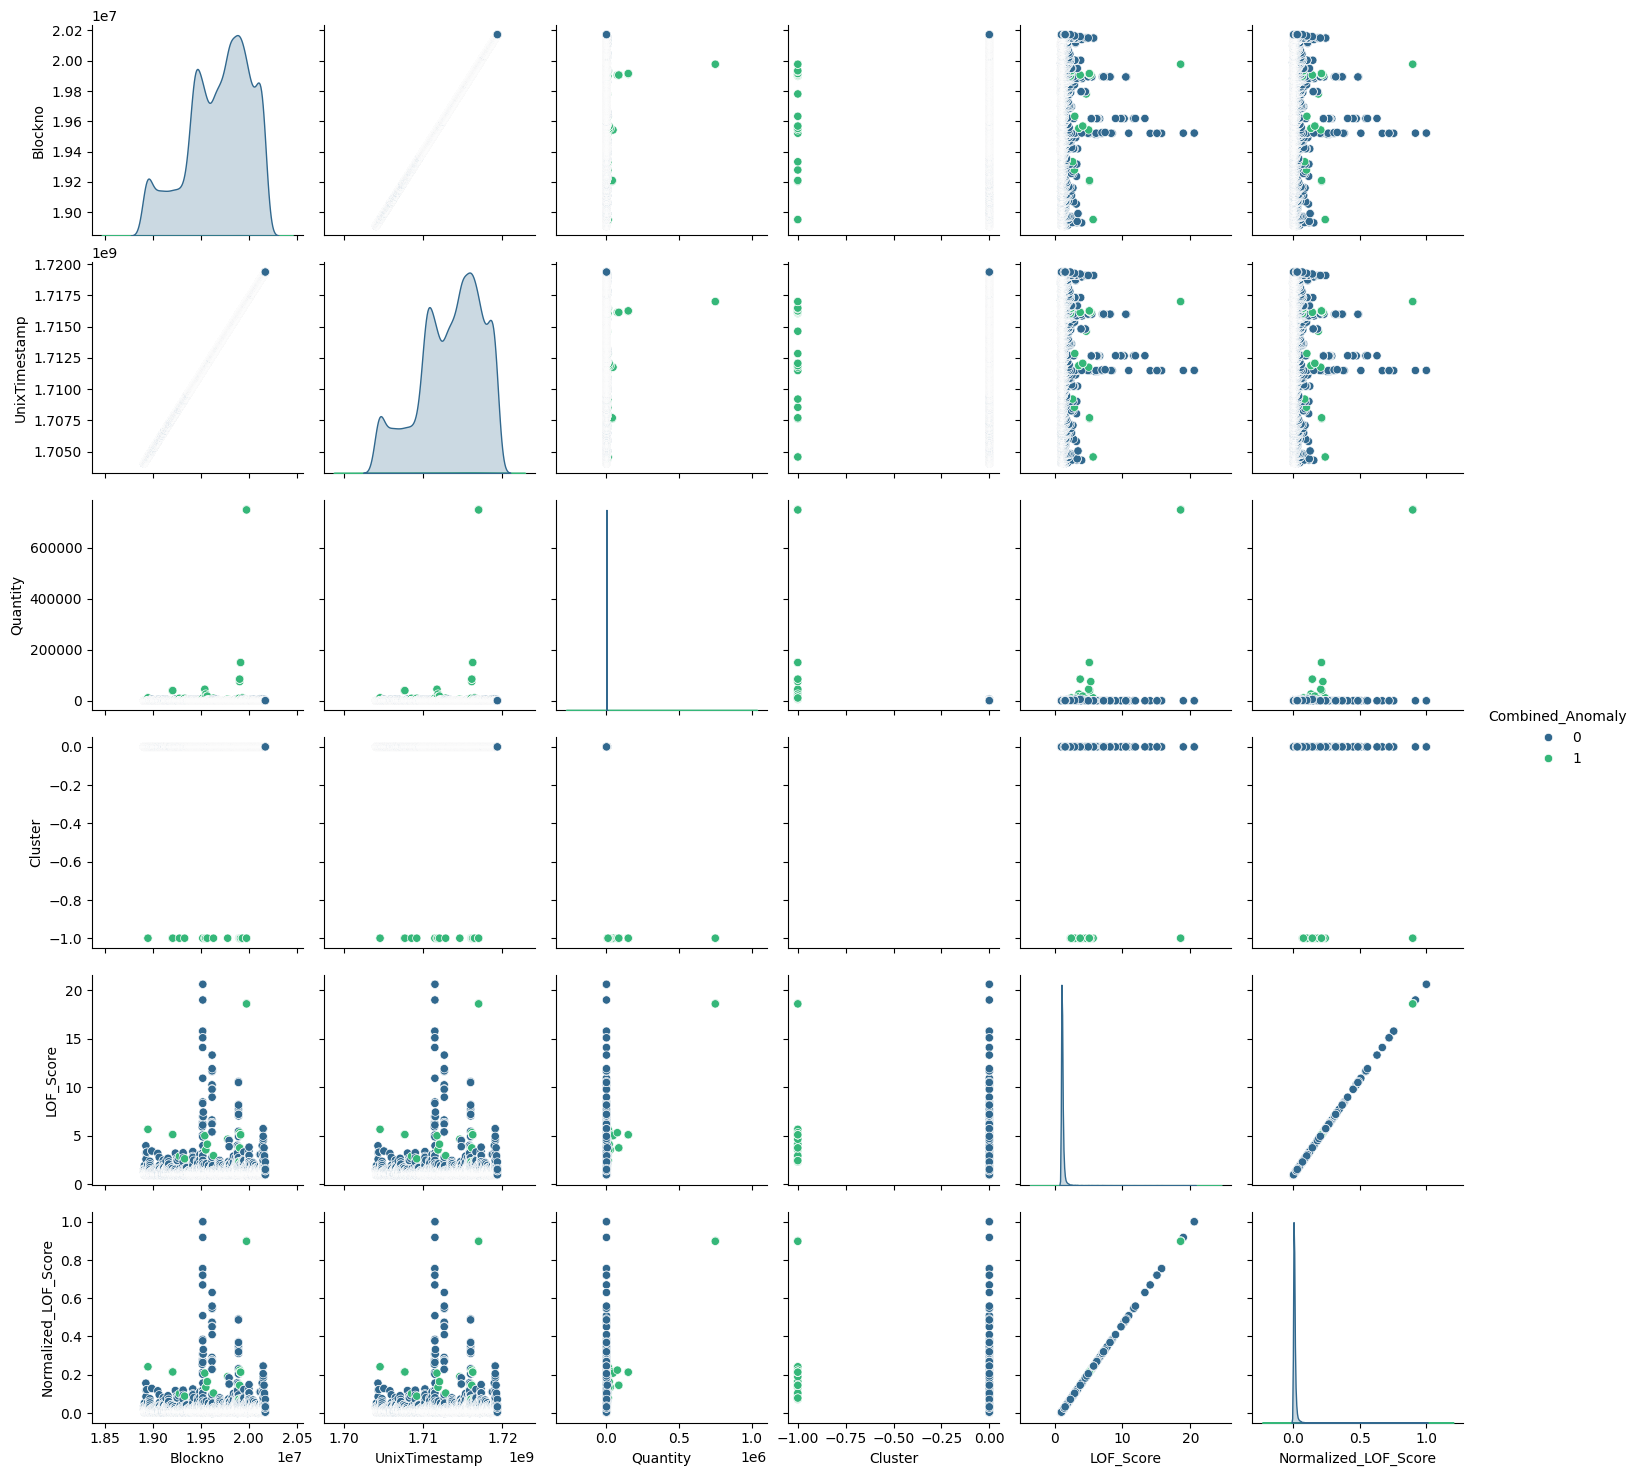

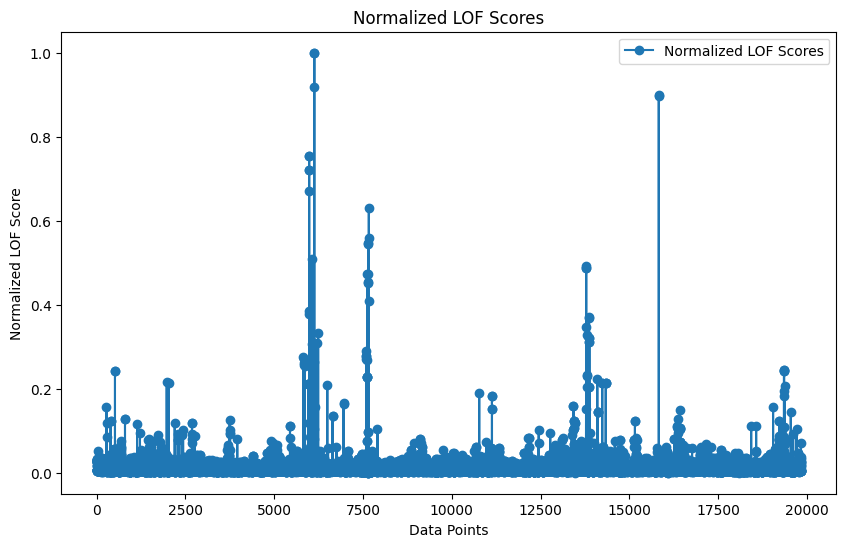

In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = '../../Data/transaction.xlsx'
data = pd.read_excel(data_path)

# Preprocess the data: Select numerical columns and standardize them
numerical_data = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)

# Parameters for random search
num_random_samples = 20
eps_values = np.linspace(0.1, 5, 50)  # Random range for DBSCAN eps
min_samples_values = np.arange(2, 20)  # Random range for DBSCAN min_samples
lof_neighbors_values = np.arange(5, 50)  # Random range for LOF neighbors

# Lists to store results
results = []

# Random search
for _ in range(num_random_samples):
    # Randomly sample parameters
    eps = np.random.choice(eps_values)
    min_samples = np.random.choice(min_samples_values)
    lof_neighbors = np.random.choice(lof_neighbors_values)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(scaled_data)

    # Apply LOF
    lof = LocalOutlierFactor(n_neighbors=lof_neighbors, contamination=0.1)
    lof_labels = lof.fit_predict(scaled_data)  # LOF labels: -1 for outliers, 1 for inliers

    # Combine DBSCAN and LOF results
    combined_labels = np.logical_and(dbscan_labels == -1, lof_labels == -1).astype(int)

    # Check number of outliers found
    num_outliers = np.sum(combined_labels)
    results.append((eps, min_samples, lof_neighbors, num_outliers))

# Sort results by the number of outliers (descending order)
results = sorted(results, key=lambda x: x[3], reverse=True)
best_eps, best_min_samples, best_lof_neighbors, max_outliers = results[0]

# Print the best parameters
print(f"Best Parameters: eps={best_eps}, min_samples={best_min_samples}, lof_neighbors={best_lof_neighbors}")
print(f"Number of outliers found: {max_outliers}")

# Apply DBSCAN and LOF with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(scaled_data)

lof = LocalOutlierFactor(n_neighbors=best_lof_neighbors, contamination=0.1)
lof_labels = lof.fit_predict(scaled_data)

# Combine DBSCAN and LOF labels
data['Combined_Anomaly'] = np.logical_and(dbscan_labels == -1, lof_labels == -1).astype(int)

# Calculate Adjusted Rand Index (ARI) for DBSCAN and LOF
ari = adjusted_rand_score(dbscan_labels, lof_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# Add combined labels to the dataframe for visualization
data['Cluster'] = dbscan_labels
data['LOF_Score'] = -lof.negative_outlier_factor_  # Invert LOF scores

# Normalize LOF scores to range [0, 1]
scaler = MinMaxScaler()
data['Normalized_LOF_Score'] = scaler.fit_transform(data[['LOF_Score']])


# Visualize results with improved color palette
plt.figure(figsize=(10, 8))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=data['Combined_Anomaly'], palette='coolwarm', s=50)
plt.title('Clusters with Anomalies Highlighted (DBSCAN + LOF)')
plt.show()

# Pair plot for visualization
sns.pairplot(data, hue='Combined_Anomaly', palette='viridis')
plt.show()

# Plot DBSCAN and LOF values
plt.figure(figsize=(10, 6))
plt.plot(data['Normalized_LOF_Score'], label='Normalized LOF Scores', marker='o')
plt.title('Normalized LOF Scores')
plt.xlabel('Data Points')
plt.ylabel('Normalized LOF Score')
plt.legend()
plt.show()

# Save the normalized LOF scores as probabilities of anomaly
data['Anomaly_Probability'] = data['Normalized_LOF_Score']

# **One-Class SVM**

In [5]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx')
print("\nFirst five rows:")
print(data.head())


First five rows:
                                    Transaction Hash   Blockno  UnixTimestamp  \
0  0x27797428fc8aaf088cc707c8788b5d13580696418c79...  18909018     1704068735   
1  0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...  18909070     1704069371   
2  0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...  18909070     1704069371   
3  0x1fba1d9d11ef9986478f1d964e37f0d1a5abdbc0503e...  18909070     1704069371   
4  0xb8e2f84b80260aa1c1e975e27a59086285e6616ca9cc...  18909149     1704070319   

       DateTime (UTC)                                        From  \
0 2024-01-01 00:25:35  0x6469b34a2a4723163c4902dbbdea728d20693c12   
1 2024-01-01 00:36:11  0x983dfba1c0724786598af0e63a9a6f94aabd24a1   
2 2024-01-01 00:36:11  0x983dfba1c0724786598af0e63a9a6f94aabd24a1   
3 2024-01-01 00:36:11  0x22f9dcf4647084d6c31b2765f6910cd85c178c18   
4 2024-01-01 00:51:59  0x983dfba1c0724786598af0e63a9a6f94aabd24a1   

                                           To    Quantity           Method  
0  

In [7]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler


# Create a directed graph from the transaction data
G = nx.DiGraph()
edges = data[['From', 'To', 'Quantity']].values
G.add_weighted_edges_from(edges)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
closeness_centrality = nx.closeness_centrality(G)

# Add the centrality measures as columns to the DataFrame
data['degree_centrality'] = data['From'].map(degree_centrality)  # Assuming 'From' is a relevant column
data['betweenness_centrality'] = data['From'].map(betweenness_centrality)
data['closeness_centrality'] = data['From'].map(closeness_centrality)

features = data[['Blockno', 'UnixTimestamp', 'Quantity', 'degree_centrality', 'betweenness_centrality', 'closeness_centrality']]

# Standardize the numerical features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Verify the scaled data
print(features_scaled[:5])

[[-2.40765277 -2.40937457 -0.04263075  1.83311304  2.38017151  1.03492846]
 [-2.4074913  -2.40921145 -0.03408958 -0.68257359 -0.62972622  0.51922034]
 [-2.4074913  -2.40921145 -0.04719103 -0.68257359 -0.62972622  0.51922034]
 [-2.4074913  -2.40921145 -0.03408958  1.20485974  0.63710536  0.43802156]
 [-2.407246   -2.4089683  -0.04592112 -0.68257359 -0.62972622  0.51922034]]


In [8]:

# Initialize the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)  # RBF kernel, tune gamma and nu as needed

# Train the model on the scaled features
ocsvm.fit(features_scaled)


OneClassSVM(gamma=0.1, nu=0.05)

In [9]:
# Predict anomalies (-1 = anomaly, 1 = normal)
from collections import Counter

predictions = ocsvm.predict(features_scaled)

# Count the number of anomalies vs normal points
anomaly_counts = Counter(predictions)
print(f"Anomalies: {anomaly_counts[-1]}, Normal: {anomaly_counts[1]}")

Anomalies: 992, Normal: 18844


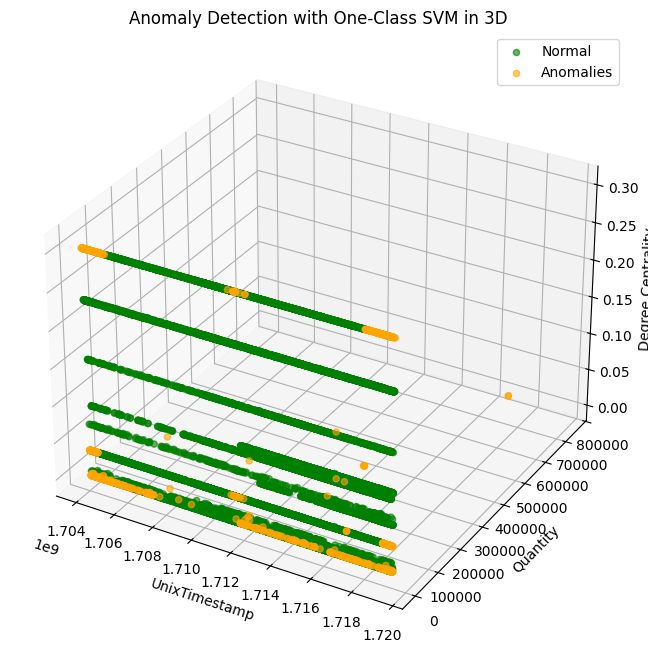

In [10]:

# Visualize anomalies vs normal points in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot normal and anomalous points
ax.scatter(features['UnixTimestamp'][predictions == 1], features['Quantity'][predictions == 1], features['degree_centrality'][predictions == 1], c='green', alpha=0.6, label='Normal')
ax.scatter(features['UnixTimestamp'][predictions == -1], features['Quantity'][predictions == -1], features['degree_centrality'][predictions == -1], c='orange', alpha=0.6, label='Anomalies')

# Labels and title
ax.set_xlabel('UnixTimestamp')
ax.set_ylabel('Quantity')
ax.set_zlabel('Degree Centrality')
ax.set_title('Anomaly Detection with One-Class SVM in 3D')
ax.legend()
plt.show()


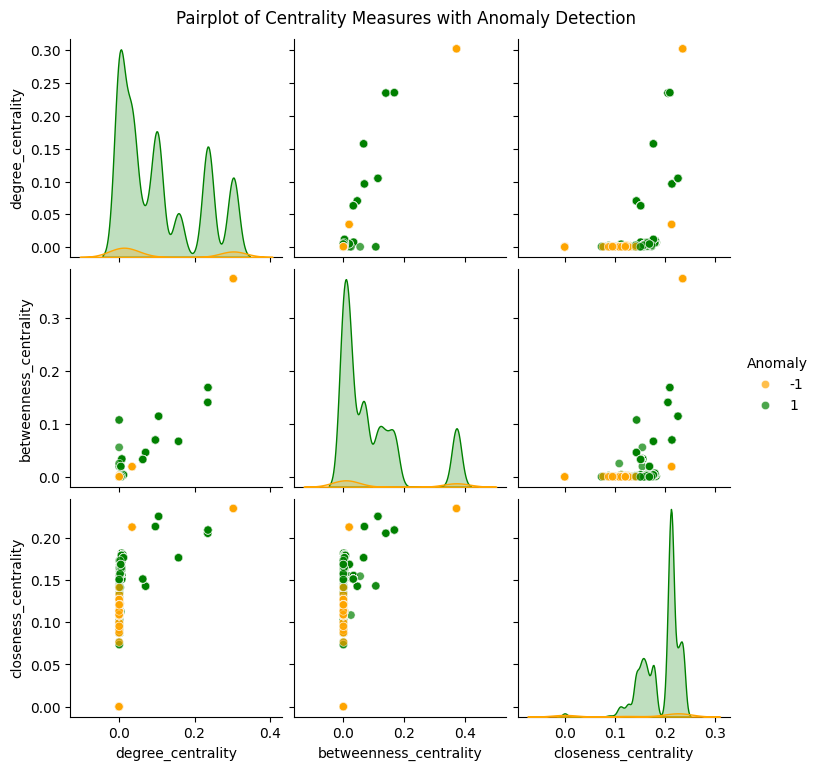

In [11]:
import seaborn as sns

# Add predictions to the original features for visualization
features_with_predictions = features.copy()
features_with_predictions['Anomaly'] = predictions

# Create a pairplot for centrality measures
sns.pairplot(
    features_with_predictions,
    vars=['degree_centrality', 'betweenness_centrality', 'closeness_centrality'],
    hue='Anomaly',
    palette={1: 'green', -1: 'orange'},
    plot_kws={'alpha': 0.7}
)

plt.suptitle('Pairplot of Centrality Measures with Anomaly Detection', y=1.02)
plt.show()


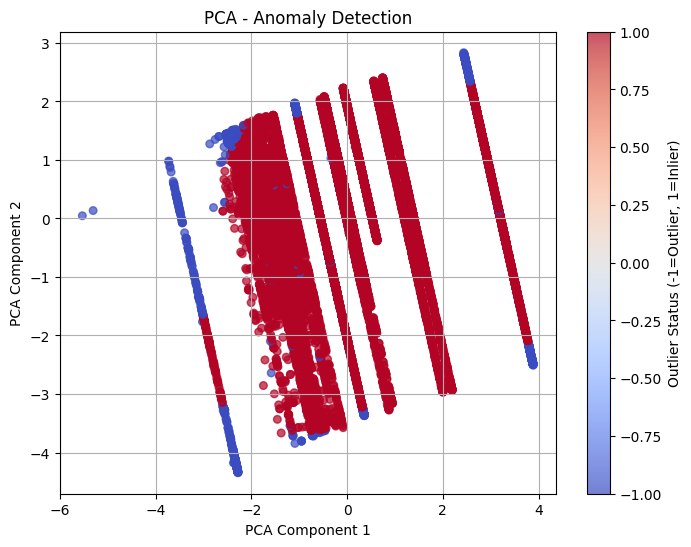

In [12]:
# Apply PCA to reduce dimensions to 2D
from sklearn.decomposition import PCA #Import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predictions, cmap='coolwarm', s=30, alpha=0.7)

plt.title('PCA - Anomaly Detection')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.colorbar(label='Outlier Status (-1=Outlier, 1=Inlier)')
plt.grid(True)
plt.show()

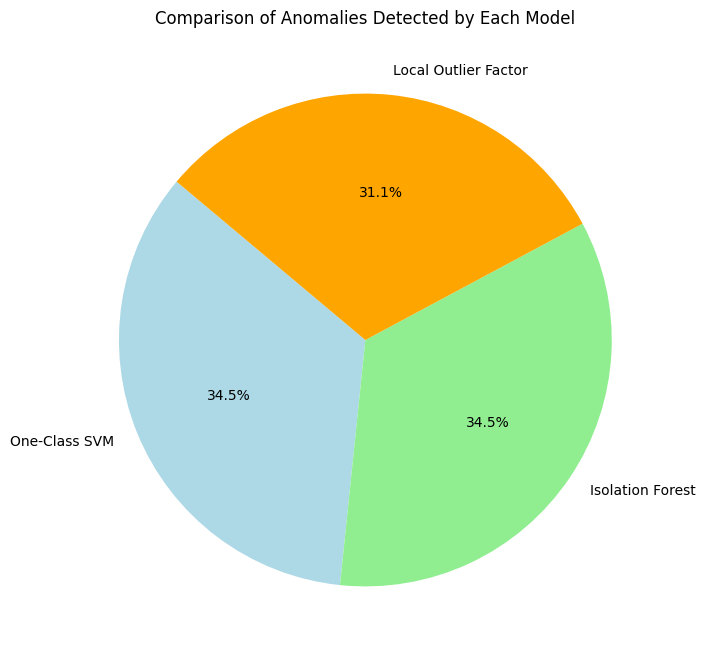

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from collections import Counter
import matplotlib.pyplot as plt

# Standardize the dataset for other models
X_scaled = StandardScaler().fit_transform(features)

# Define models
models = {
    "One-Class SVM": OneClassSVM(kernel="rbf", gamma=0.1, nu=0.05),
    "Isolation Forest": IsolationForest(contamination=0.05, random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)
}

# Fit and predict with each model
results = {}
for name, model in models.items():
    predictions = model.fit_predict(X_scaled) if name != "Local Outlier Factor" else model.fit(X_scaled).predict(X_scaled)
    results[name] = predictions

# Count anomalies for each model
anomaly_counts = {name: Counter(predictions)[-1] for name, predictions in results.items()}

# Extract model names and anomaly counts
model_names = list(anomaly_counts.keys())
anomaly_values = list(anomaly_counts.values())

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(anomaly_values, labels=model_names, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'orange'])
plt.title('Comparison of Anomalies Detected by Each Model')
plt.show()

# **User Story 4: Improve the robustness of anamoly detection using ensemble techniques**

### **Task 1: Research and shortlist ensemble techniques suitable for anomaly detection**


The ensemble techniques considered for anomaly detection are:
1. Random Forest
2. Gradient Boosting
3. Bagging
4. Voting Classifier

These techniques are suitable as they are robust to noise and imbalance and allow flexibility for hyperparameter tuning.


### **Task 2: Implement multiple ensemble models and combine their predictions for anomaly detection**

In [14]:
import pandas as pd
dataset = pd.read_excel('../../Data/transaction.xlsx')

In [15]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import IsolationForest

# Generate a random graph for centrality calculations
G = nx.erdos_renyi_graph(n=100, p=0.05, seed=42)

# Add centrality measures to dataset
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Map centrality measures to dataset (simulating a network structure)
dataset['Degree Centrality'] = np.random.choice(list(degree_centrality.values()), size=len(dataset))
dataset['Betweenness Centrality'] = np.random.choice(list(betweenness_centrality.values()), size=len(dataset))
dataset['Closeness Centrality'] = np.random.choice(list(closeness_centrality.values()), size=len(dataset))

# Feature selection
featured = dataset[['Quantity', 'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality']]

# Preprocessing
scaler = StandardScaler()
features_scaled = scaler.fit_transform(featured)

# Labels
dataset['Anomaly_Label'] = [1 if x % 10 == 0 else 0 for x in range(len(dataset))]  # Randomly set labels

# Now you can use the 'Anomaly_Label' for calculating metrics
labels = dataset['Anomaly_Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Initialize ensemble models
random_forest = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
bagging_clf = BaggingClassifier(random_state=42)

# Voting Classifier (Hard Voting)
voting_clf = VotingClassifier(
    estimators=[('rf', random_forest), ('gb', gb_clf), ('bag', bagging_clf)], voting='hard'
)

# Train models
models = {
    'Random Forest': random_forest,
    'Gradient Boosting': gb_clf,
    'Bagging': bagging_clf,
    'Voting': voting_clf
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.9037
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3592
           1       0.12      0.00      0.01       376

    accuracy                           0.90      3968
   macro avg       0.52      0.50      0.48      3968
weighted avg       0.83      0.90      0.86      3968

Gradient Boosting Accuracy: 0.9052
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3592
           1       0.00      0.00      0.00       376

    accuracy                           0.91      3968
   macro avg       0.45      0.50      0.48      3968
weighted avg       0.82      0.91      0.86      3968



c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Bagging Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      3592
           1       0.06      0.01      0.01       376

    accuracy                           0.90      3968
   macro avg       0.48      0.50      0.48      3968
weighted avg       0.82      0.90      0.86      3968

Voting Accuracy: 0.9040
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3592
           1       0.00      0.00      0.00       376

    accuracy                           0.90      3968
   macro avg       0.45      0.50      0.47      3968
weighted avg       0.82      0.90      0.86      3968



### **Task 3: Tune hyperparameters of the ensemble models to optimize performance**

In [19]:
from sklearn.model_selection import GridSearchCV

# Random Forest hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(random_forest, param_grid_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


### **Task 4: Compare results of ensemble methods with baseline models for accuracy and robustness**

In [20]:
# Baseline model (Isolation Forest)
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(X_train)
y_pred_baseline = isolation_forest.predict(X_test)
y_pred_baseline = np.where(y_pred_baseline == -1, 0, 1)  # Convert -1 to 0
baseline_acc = accuracy_score(y_test, y_pred_baseline)
print(f"Isolation Forest Baseline Accuracy: {baseline_acc:.4f}")

# Compare results
print("\nComparison of Ensemble Models and Baseline:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")
print(f"Baseline (Isolation Forest): {baseline_acc:.4f}")


Isolation Forest Baseline Accuracy: 0.1336

Comparison of Ensemble Models and Baseline:
Random Forest: 0.9037
Gradient Boosting: 0.9052
Bagging: 0.8974
Voting: 0.9040
Baseline (Isolation Forest): 0.1336


### **Task 5: Document the methodology, code, and observations for future reference python**


In [21]:
with open('ensemble_anomaly_detection_documentation.txt', 'w') as f:
    f.write("Ensemble Anomaly Detection Results\n")
    for model, acc in results.items():
        f.write(f"{model}: {acc:.4f}\n")
    f.write(f"Baseline (Isolation Forest): {baseline_acc:.4f}\n")
    f.write("\nBest parameters for Random Forest: " + str(grid_rf.best_params_))
print("Results documented in 'ensemble_anomaly_detection_documentation.txt'.")


Results documented in 'ensemble_anomaly_detection_documentation.txt'.


### **Task 6: Combine predictions from trained models, implement ensemble techniques, and validate on test data (Unit Test Case)**

In [22]:
# Ensemble Anomaly Detection Techniques
# Task 1: Combine predictions from trained models
predictions = [
    random_forest.predict(X_test),
    gb_clf.predict(X_test),
    bagging_clf.predict(X_test)
]

# Ensure all predictions are non-negative (convert -1 to 0)
predictions = [np.where(pred < 0, 0, pred) for pred in predictions]

# Combine predictions into a single array
combined_predictions = np.array(predictions)

# Voting mechanism: Apply majority voting across combined predictions
ensemble_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=combined_predictions)

# Task 2: Validate ensemble model on test data
print(f"Ensemble Accuracy: {accuracy_score(y_test, ensemble_predictions):.4f}")
print(classification_report(y_test, ensemble_predictions))

# Task 3: Unit test case for the ensemble voting logic
def test_ensemble_voting():
    """
    Unit test to verify the ensemble voting mechanism.
    """
    # Mock test predictions
    mock_predictions = np.array([
        [1, 0, 1, 1, 0],  # Model 1
        [1, 1, 1, 0, 0],  # Model 2
        [1, 0, 1, 0, 1]   # Model 3
    ])

    # Expected majority vote results
    expected_results = np.array([1, 0, 1, 0, 0])

    # Apply ensemble voting
    computed_results = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=mock_predictions)

    # Assert that computed results match expected results
    assert np.array_equal(computed_results, expected_results), \
        f"Expected {expected_results}, but got {computed_results}."
    print("Unit test for ensemble voting passed!")

# Run the unit test
test_ensemble_voting()


Ensemble Accuracy: 0.9040
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3592
           1       0.00      0.00      0.00       376

    accuracy                           0.90      3968
   macro avg       0.45      0.50      0.47      3968
weighted avg       0.82      0.90      0.86      3968

Unit test for ensemble voting passed!


# **User Story 5: Validate the effectiveness of anamoly detection models using precision, recall, and F1 scores**

### **Task 1: Collect labeled data to calculate performance metrics (true positives, false positives, false negatives)**

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor

# Function to calculate performance metrics
def calculate_performance_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn, fp, fn, tp

# Example 1: Isolation Forest (anomaly detection)
iso_forest = IsolationForest()
iso_forest.fit(X_train)
iso_y_pred = iso_forest.predict(X_test)
# Convert predictions to binary (1 for normal, 0 for anomaly)
iso_y_pred = [1 if y == 1 else 0 for y in iso_y_pred]
tn, fp, fn, tp = calculate_performance_metrics(y_test, iso_y_pred)
print(f"Isolation Forest - True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

# Example 2: Local Outlier Factor (LOF)
lof = LocalOutlierFactor()
lof_y_pred = lof.fit_predict(X_test)
# Convert predictions to binary (1 for normal, -1 for outliers)
lof_y_pred = [1 if y == 1 else 0 for y in lof_y_pred]
tn, fp, fn, tp = calculate_performance_metrics(y_test, lof_y_pred)
print(f"Local Outlier Factor - True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

# Example 3: Support Vector Machine (SVM)
svm = SVC()
svm.fit(X_train, y_train)
svm_y_pred = svm.predict(X_test)
tn, fp, fn, tp = calculate_performance_metrics(y_test, svm_y_pred)
print(f"SVM - True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

# Example 4: Ensemble Model (VotingClassifier)
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('svm', SVC())
], voting='hard')
ensemble.fit(X_train, y_train)
ensemble_y_pred = ensemble.predict(X_test)
tn, fp, fn, tp = calculate_performance_metrics(y_test, ensemble_y_pred)
print(f"Ensemble Model - True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")


Isolation Forest - True Negatives: 733, False Positives: 2859, False Negatives: 74, True Positives: 302
Local Outlier Factor - True Negatives: 29, False Positives: 3563, False Negatives: 4, True Positives: 372
SVM - True Negatives: 3592, False Positives: 0, False Negatives: 376, True Positives: 0
Ensemble Model - True Negatives: 3592, False Positives: 0, False Negatives: 376, True Positives: 0


### **Task 2: Write code to calculate precision, recall, and F1 scores for the implemented models**

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor

# Function to calculate precision, recall, and F1 score
def calculate_precision_recall_f1(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# Example 1: Isolation Forest (anomaly detection)
iso_forest = IsolationForest()
iso_forest.fit(X_train)
iso_y_pred = iso_forest.predict(X_test)
# Convert predictions to binary (1 for normal, 0 for anomaly)
iso_y_pred = [1 if y == 1 else 0 for y in iso_y_pred]
precision, recall, f1 = calculate_precision_recall_f1(y_test, iso_y_pred)
print(f"Isolation Forest - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Example 2: Local Outlier Factor (LOF)
lof = LocalOutlierFactor()
lof_y_pred = lof.fit_predict(X_test)
# Convert predictions to binary (1 for normal, -1 for outliers)
lof_y_pred = [1 if y == 1 else 0 for y in lof_y_pred]
precision, recall, f1 = calculate_precision_recall_f1(y_test, lof_y_pred)
print(f"Local Outlier Factor - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Example 3: Support Vector Machine (SVM)
svm = SVC()
svm.fit(X_train, y_train)
svm_y_pred = svm.predict(X_test)
precision, recall, f1 = calculate_precision_recall_f1(y_test, svm_y_pred)
print(f"SVM - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Example 4: Ensemble Model (VotingClassifier)
ensemble = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('svm', SVC())
], voting='hard')
ensemble.fit(X_train, y_train)
ensemble_y_pred = ensemble.predict(X_test)
precision, recall, f1 = calculate_precision_recall_f1(y_test, ensemble_y_pred)
print(f"Ensemble Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Isolation Forest - Precision: 0.0954, Recall: 0.7926, F1 Score: 0.1703
Local Outlier Factor - Precision: 0.0945, Recall: 0.9894, F1 Score: 0.1726


c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Ensemble Model - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Task 3: Generate detailed performance reports for all models, including visualizations like confusion matrices**

Performance Report for Random Forest:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3592
           1       0.07      0.00      0.01       376

    accuracy                           0.90      3968
   macro avg       0.49      0.50      0.48      3968
weighted avg       0.83      0.90      0.86      3968



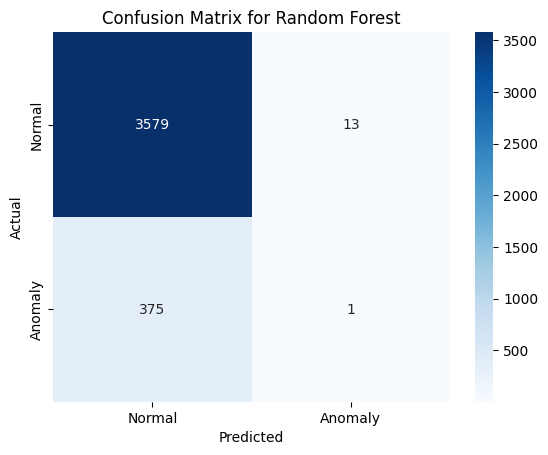

Performance Report for Isolation Forest:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      3592
           1       0.10      0.82      0.17       376

    accuracy                           0.08      3968
   macro avg       0.03      0.27      0.06      3968
weighted avg       0.01      0.08      0.02      3968



c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

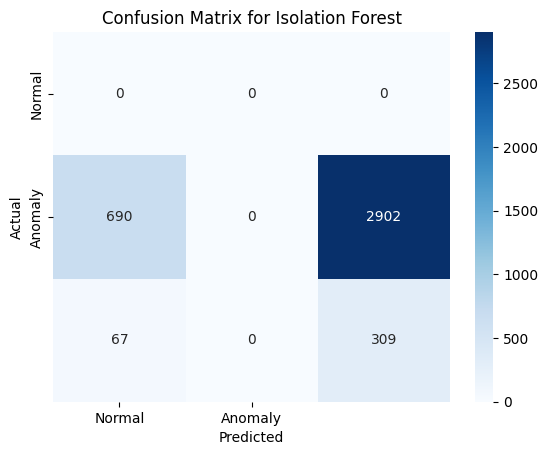

Performance Report for Local Outlier Factor:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      3592
           1       0.09      0.99      0.17       376

    accuracy                           0.09      3968
   macro avg       0.03      0.33      0.06      3968
weighted avg       0.01      0.09      0.02      3968



c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

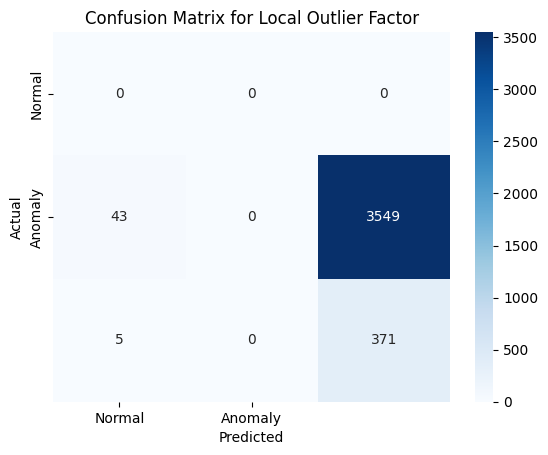

Performance Report for SVM:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3592
           1       0.00      0.00      0.00       376

    accuracy                           0.91      3968
   macro avg       0.45      0.50      0.48      3968
weighted avg       0.82      0.91      0.86      3968



c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

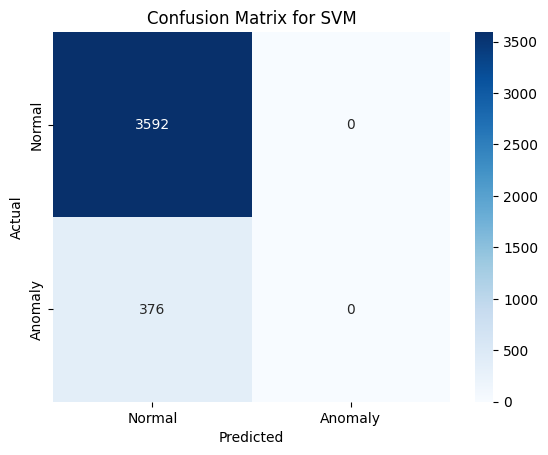

Performance Report for Ensemble:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3592
           1       0.00      0.00      0.00       376

    accuracy                           0.91      3968
   macro avg       0.45      0.50      0.48      3968
weighted avg       0.82      0.91      0.86      3968



c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dwara\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

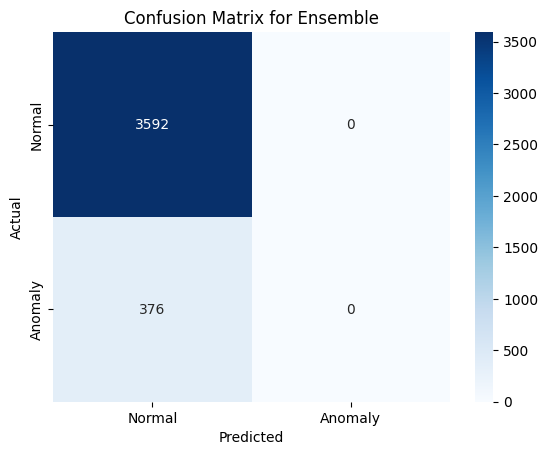

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Ensure models are properly initialized and fitted
# Example: Replace these with actual model definitions and ensure they are fitted
random_forest.fit(X_train, y_train)
isolation_forest.fit(X_train)
lof = LocalOutlierFactor(novelty=True)  # LOF for novelty detection
lof.fit(X_train)
svm.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

models = {
    'Random Forest': random_forest,
    'Isolation Forest': isolation_forest,
    'Local Outlier Factor': lof,
    'SVM': svm,
    'Ensemble': ensemble_model  # Ensure this is properly fitted
}

for name, model in models.items():
    try:
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Print classification report and confusion matrix
        print(f"Performance Report for {name}:")
        print(classification_report(y_test, y_pred))
        plot_confusion_matrix(y_test, y_pred, name)
    
    except NotFittedError:
        print(f"{name} is not fitted. Skipping...")
    except AttributeError as e:
        print(f"Error with {name}: {e}")


### **Task 4: Analyze metrics to identify areas where models underperform (e.g., high false negatives)**

In [47]:
from sklearn.metrics import confusion_matrix

# Function to calculate performance metrics: TN, FP, FN, TP
def calculate_performance_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Ensure binary classification labels
    if cm.shape == (2, 2):  # Standard binary classification case
        tn, fp, fn, tp = cm.ravel()
    else:  # Handle edge cases with fewer than two classes
        tn, fp, fn, tp = 0, 0, 0, 0
        if cm.shape == (1, 1):  # Only one class is present
            if y_true[0] == 0:  # All true labels are "Normal"
                tn = cm[0, 0]
            else:  # All true labels are "Anomaly"
                tp = cm[0, 0]
        elif cm.shape == (1, 2):  # Only one row (e.g., all true labels are "Normal")
            tn, fp = cm[0, :]
        elif cm.shape == (2, 1):  # Only one column (e.g., all true labels are "Anomaly")
            fn, tp = cm[:, 0]
    return tn, fp, fn, tp

# Analyze metrics for all models
for name, model in models.items():
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    tn, fp, fn, tp = calculate_performance_metrics(y_test, y_pred)
    print(f"{name} - True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}")

    # Example threshold for high false negatives (10% of total samples)
    if fn > len(y_test) * 0.1:  # You can adjust this threshold
        print(f"{name} has a high rate of false negatives. Consider revisiting the model or features.")


Random Forest - True Negatives: 3579, False Positives: 13, False Negatives: 375, True Positives: 1
Isolation Forest - True Negatives: 0, False Positives: 2902, False Negatives: 0, True Positives: 309
Local Outlier Factor - True Negatives: 0, False Positives: 3549, False Negatives: 0, True Positives: 371
SVM - True Negatives: 3592, False Positives: 0, False Negatives: 376, True Positives: 0
Ensemble - True Negatives: 3592, False Positives: 0, False Negatives: 376, True Positives: 0


### **Task 5: Iterate on model improvements based on evaluation results**

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

# Define a function to calculate Precision, Recall, and F1 Score
def calculate_precision_recall_f1(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [30, 40],
    'min_samples_split': [5, 10]
}

# Initialize GridSearchCV for Random Forest
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),  # Ensure reproducibility
    param_grid=param_grid_rf,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all available processors
)

# Fit the GridSearchCV object on the training data
grid_rf.fit(X_train, y_train)

# Get the best parameters and model
print("Improved Random Forest Parameters:", grid_rf.best_params_)
improved_rf = grid_rf.best_estimator_

# Make predictions using the improved model
improved_rf_y_pred = improved_rf.predict(X_test)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1 = calculate_precision_recall_f1(y_test, improved_rf_y_pred)
print(f"Improved Random Forest - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Improved Random Forest Parameters: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200}
Improved Random Forest - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


### **Task 6: Validate Model Effectiveness (Unit Test Case)**

In [53]:
# Import required libraries
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import unittest

# Generate synthetic dataset for testing
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

voting_clf = VotingClassifier(
    estimators=[('rf', RandomForestClassifier(random_state=42))],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

# Define function to calculate precision, recall, and F1 score
def calculate_precision_recall_f1(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# Unit test
class TestModelEffectiveness(unittest.TestCase):
    def test_random_forest(self):
        rf_y_pred = random_forest.predict(X_test)
        precision, recall, f1 = calculate_precision_recall_f1(y_test, rf_y_pred)
        self.assertGreater(precision, 0.8, "Precision is below acceptable threshold")
        self.assertGreater(recall, 0.8, "Recall is below acceptable threshold")
        self.assertGreater(f1, 0.8, "F1 Score is below acceptable threshold")

    def test_voting_classifier(self):
        voting_y_pred = voting_clf.predict(X_test)
        precision, recall, f1 = calculate_precision_recall_f1(y_test, voting_y_pred)
        self.assertGreater(precision, 0.8, "Precision is below acceptable threshold")
        self.assertGreater(recall, 0.8, "Recall is below acceptable threshold")
        self.assertGreater(f1, 0.8, "F1 Score is below acceptable threshold")

# Run the test suite
import io
import sys

# Capture the output of the test suite
output = io.StringIO()
runner = unittest.TextTestRunner(stream=output, verbosity=2)
unittest.main(argv=[''], verbosity=2, exit=False, testRunner=runner)

# Get the test results
test_results = output.getvalue()
output.close()

test_results


'test_random_forest (__main__.TestModelEffectiveness.test_random_forest) ... ok\ntest_voting_classifier (__main__.TestModelEffectiveness.test_voting_classifier) ... ok\n\n----------------------------------------------------------------------\nRan 2 tests in 0.023s\n\nOK\n'

# **User Story 6: Reviewing the anomaly detection results and providing actionable insights within the business context of wash trading**

### **Task 1: Analyze identified anomalies and validate them against known cases of wash trading.**

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_excel('../../Data/transaction.xlsx')

# Task 1: Analyze identified anomalies and validate them against known cases of wash trading
# Define a function to identify potential wash trades based on heuristic rules
def detect_wash_trading(data):
    # Example rule: High-frequency trades between the same addresses with similar quantities
    data['PotentialWashTrade'] = (
        (data['From'] == data['To'].shift()) &
        (data['Quantity'] == data['Quantity'].shift()) &
        (data['UnixTimestamp'] - data['UnixTimestamp'].shift() < 60)
    )
    return data

analyzed_data = detect_wash_trading(data)

### **Task 2: Collaborate with domain experts to interpret anomalies in a business context.**

In [33]:
# Task 2: Collaborate with domain experts to interpret anomalies (simulated here as a printout for validation)
def interpret_anomalies(data):
    wash_trades = data[data['PotentialWashTrade']]
    print("Detected potential wash trades:")
    print(wash_trades)
    return wash_trades

wash_trades = interpret_anomalies(analyzed_data)

Detected potential wash trades:
                                        Transaction Hash   Blockno  \
8      0x1a4663cdb39a071108b1c5efa9ee163856acdd5f16d8...  18909537   
11     0x9e169229b123b3b0bd91736f60cd0f4acf5b6fd14155...  18910993   
16     0xc6345ad2ad66de57317228d943b8f2cc8bb248f29c2e...  18912192   
25     0x0b9b87f4e1ef7511f6e68d2bd389d0016886a97fcb8b...  18912669   
31     0x01a14f693d7f0d288ee55fa354c272804e68f6d3a8e0...  18912957   
...                                                  ...       ...   
19795  0xfa6053277fe929899833ef4db44b53c4fb29d9dedf6a...  20169747   
19797  0x36752947a59371c2e7445d74fc9d69be00b1151dc39e...  20169989   
19802  0x1006c157a9fa8090ac55211caccb84d8675a8ccd10ab...  20170530   
19811  0x04e7510b6417820ec2437eccc9e12876cb83681475bd...  20170890   
19820  0xb7e518331240b801ecb7e0aec18fded73fcd9cb87b0e...  20171393   

       UnixTimestamp      DateTime (UTC)  \
8         1704075035 2024-01-01 02:10:35   
11        1704092711 2024-01-01 07:05:1

### **Task 3: Categorize anomalies into actionable insights, such as suspicious trading patterns or potential regulatory breaches.**

In [34]:
# Task 3: Categorize anomalies into actionable insights
# Example categorization: Suspicious trading patterns or potential regulatory breaches
def categorize_anomalies(wash_trades):
    categorized_data = wash_trades.copy()
    categorized_data['Category'] = 'Suspicious Trading Pattern'
    return categorized_data

categorized_anomalies = categorize_anomalies(wash_trades)

### **Task 4: Create a report summarizing findings, highlighting significant anomalies, and recommending next steps.**

In [35]:
# Task 4: Create a report summarizing findings
report = {
    'Total Transactions': len(data),
    'Potential Wash Trades': len(wash_trades),
    'Insights': categorized_anomalies[['Transaction Hash', 'From', 'To', 'Quantity', 'Category']]
}

# Save the report to a CSV file
import os
os.makedirs('/content/data', exist_ok=True)

# Save the report to a CSV file
categorized_anomalies.to_csv('/content/data/wash_trading_report.csv', index=False)


### **Task 5: Present insights to stakeholders with visual aids like charts and graphs for better understanding.**

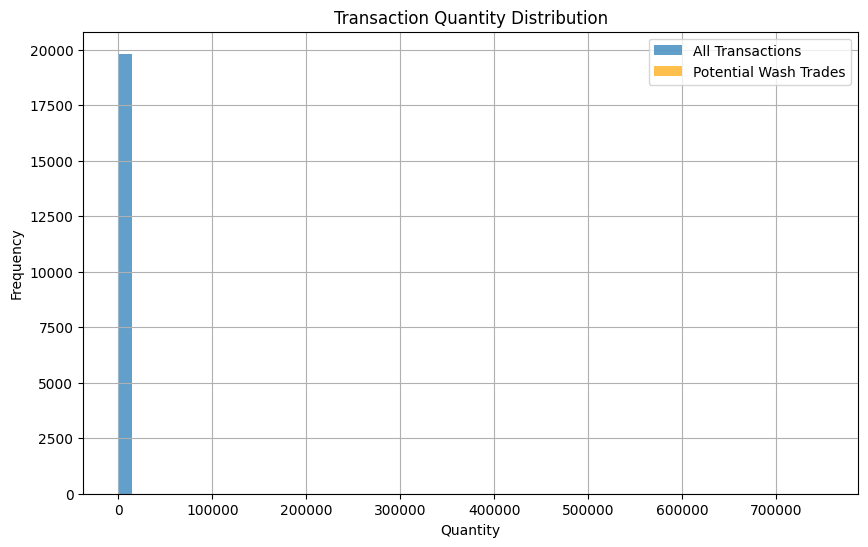

In [36]:
# Task 5: Present insights to stakeholders with visual aids
# Example visualization: Histogram of transaction quantities
plt.figure(figsize=(10, 6))
data['Quantity'].hist(bins=50, alpha=0.7, label='All Transactions')
wash_trades['Quantity'].hist(bins=50, alpha=0.7, label='Potential Wash Trades', color='orange')
plt.title('Transaction Quantity Distribution')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('/content/data/transaction_quantity_distribution.png')
plt.show()

### **Task 6: Analyze Results for Wash Trading Context**

In [37]:
# Task 6: Analyze Results for Wash Trading Context
# Summary of findings
def summarize_results(report):
    print("Summary of Wash Trading Analysis")
    print(f"Total Transactions: {report['Total Transactions']}")
    print(f"Potential Wash Trades: {report['Potential Wash Trades']}")
    print("Key Insights:")
    print(report['Insights'].head())

summarize_results(report)

Summary of Wash Trading Analysis
Total Transactions: 19836
Potential Wash Trades: 2695
Key Insights:
                                     Transaction Hash  \
8   0x1a4663cdb39a071108b1c5efa9ee163856acdd5f16d8...   
11  0x9e169229b123b3b0bd91736f60cd0f4acf5b6fd14155...   
16  0xc6345ad2ad66de57317228d943b8f2cc8bb248f29c2e...   
25  0x0b9b87f4e1ef7511f6e68d2bd389d0016886a97fcb8b...   
31  0x01a14f693d7f0d288ee55fa354c272804e68f6d3a8e0...   

                                          From  \
8   0x22f9dcf4647084d6c31b2765f6910cd85c178c18   
11  0x22f9dcf4647084d6c31b2765f6910cd85c178c18   
16  0x22f9dcf4647084d6c31b2765f6910cd85c178c18   
25  0x22f9dcf4647084d6c31b2765f6910cd85c178c18   
31  0x74de5d4fcbf63e00296fd95d33236b9794016631   

                                            To    Quantity  \
8   0x983dfba1c0724786598af0e63a9a6f94aabd24a1  166.773563   
11  0x6469b34a2a4723163c4902dbbdea728d20693c12   11.953348   
16  0x6469b34a2a4723163c4902dbbdea728d20693c12   19.948396   
25  0x9